In [31]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.util import load
import os
os.chdir('../..')

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

In [2]:
#filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/ttHbb/store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2500000/6BF93845-49D5-2547-B860-4F7601074715.root"
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/ttHbb/store/mc/RunIISummer20UL18NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/130000/44187D37-0301-3942-A6F7-C723E9F4813D.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=500000).events()

In [4]:
events

<NanoEventsArray [<event 1:694:693011>, ... ] type='10000 * event'>

# btagSF computation

In [3]:
import correctionlib
cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/2018_UL/btagging.json.gz")

In [4]:
corr = cset["deepJet_shape"]

In [5]:
corr.description

'deepJet reshaping scale factors for UL 2018. The scale factors have 8 default uncertainty sources (hf,lf,hfstats1/2,lfstats1/2,cferr1/2). All except the cferr1/2 uncertainties are to be applied to light and b jets. The cferr1/2 uncertainties are to be applied to c jets. hf/lfstats1/2 uncertainties are to be decorrelated between years, the others correlated. Additional jes-varied scale factors are supplied to be applied for the jes variations.'

In [7]:
mask = (events.Jet.pt >= 30) & (abs(events.Jet.eta) < 2.5)

In [8]:
flavour = ak.to_numpy(ak.flatten(events.Jet.hadronFlavour[mask]))
abseta = np.abs(ak.to_numpy(ak.flatten(events.Jet.eta[mask])))
pt = ak.to_numpy(ak.flatten(events.Jet.pt[mask]))
discr = ak.to_numpy(ak.flatten(events.Jet.btagDeepFlavB[mask]))
njet = ak.num(events.Jet[mask])

In [12]:
w = corr.evaluate("central", flavour, abseta, pt, discr)
weight = ak.unflatten(w, njet)

In [13]:
event_weight= ak.prod(weight, axis=-1)

In [14]:
weight[0:10].tolist()

[[0.892459452152, 1.1656756978985454, 1.1749574647350498],
 [0.922901451588, 1.2474655114519857, 0.9010124804992585],
 [0.9877053857215878, 0.9237691850699223],
 [1.3911254231799035,
  0.922901451588,
  0.922487258911,
  1.043259006215633,
  1.2636238451666324,
  1.1553113559981159],
 [1.126291075348247, 0.9820121197501579],
 [1.2375444182754247,
  0.892459452152,
  1.1285838313371372,
  0.922487258911,
  1.2327920491129214],
 [0.9867450798981254, 0.922487258911],
 [0.9790917325371903,
  0.9450608104527708,
  1.018647049217641,
  1.325376296972817],
 [1.0415900525345414, 0.922487258911, 0.922487258911, 0.9441756694172634],
 [1.2253446251960833, 0.7259000916546433, 1.058576753606894]]

Text(0, 1, 'btag SF')

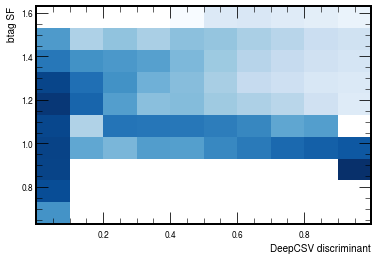

In [15]:
plt.hist2d(discr, w, norm=LogNorm(), cmap="Blues")
plt.xlabel("DeepCSV discriminant")
plt.ylabel("btag SF")

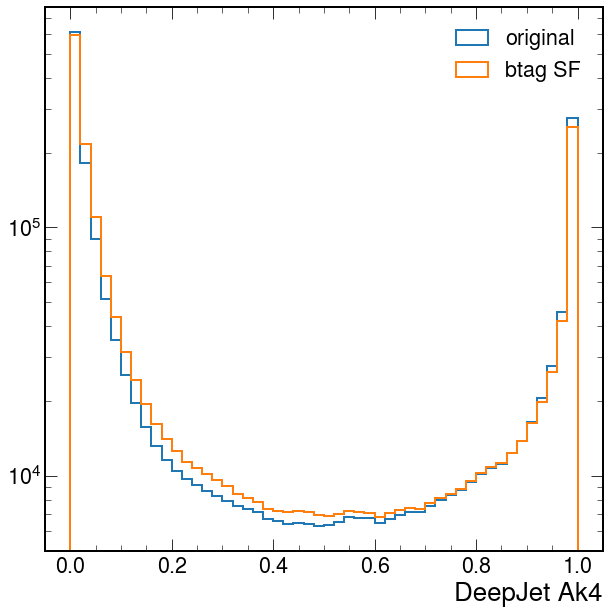

In [18]:
plt.hist(discr, range=(0,1), bins=50, histtype="step",linewidth=2, label="original")
plt.hist(discr, weights=w, range=(0,1), bins=50, histtype="step", linewidth=2,label="btag SF")
plt.legend()
plt.xlabel("DeepJet Ak4")
plt.yscale("log")

(array([953252.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  32397., 737690.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

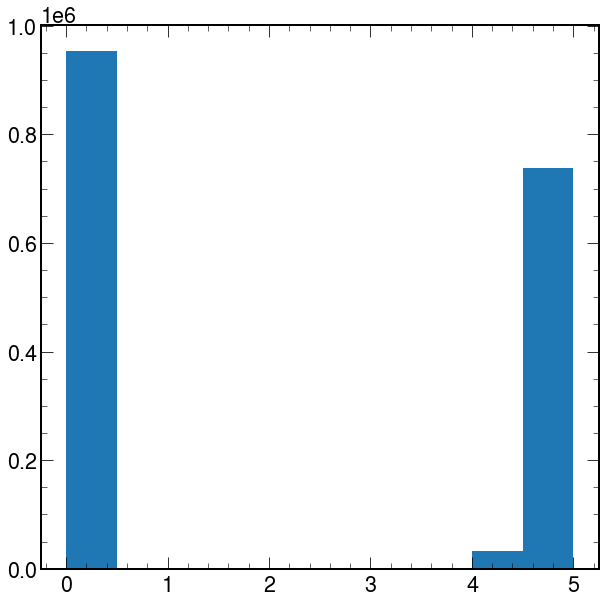

In [79]:
plt.hist(flavour)

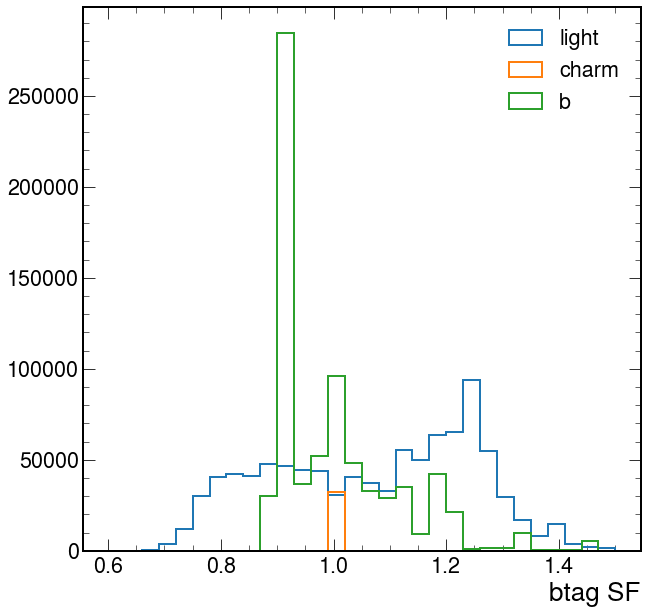

In [110]:
plt.hist(w[flavour==0], bins=30, range=(0.6,1.5),histtype="step",linewidth=2, label="light" )
plt.hist(w[flavour==4], bins=30, range=(0.6,1.5),histtype="step", linewidth=2,label="charm" )
plt.hist(w[flavour==5], bins=30, range=(0.6,1.5),histtype="step", linewidth=2, label="b")
plt.xlabel("btag SF")
plt.legend()

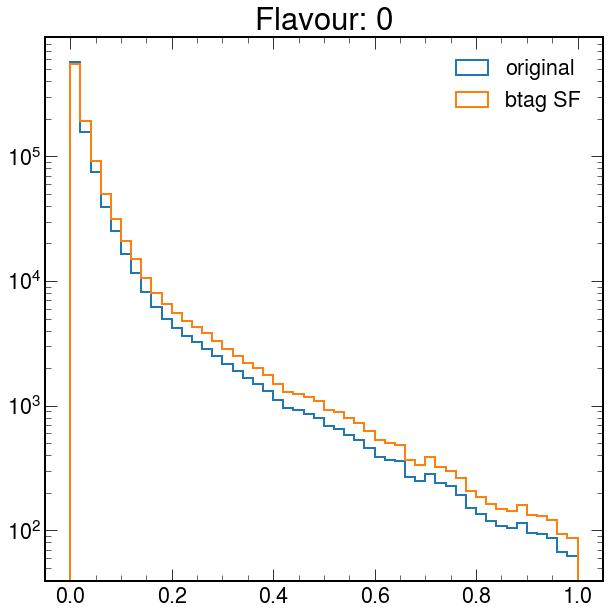

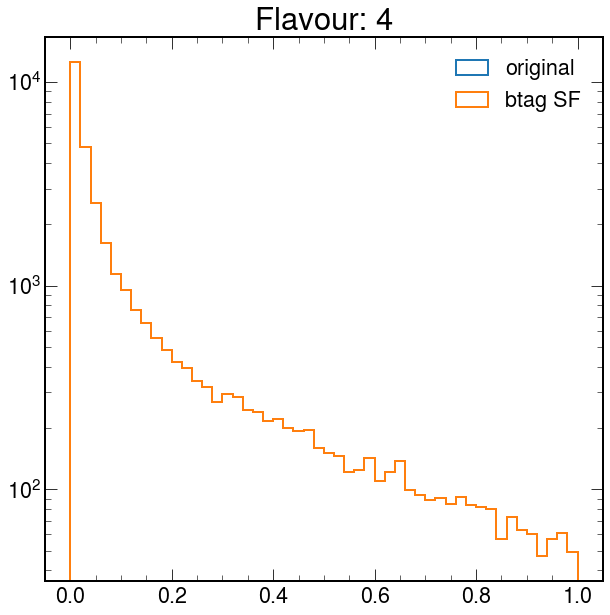

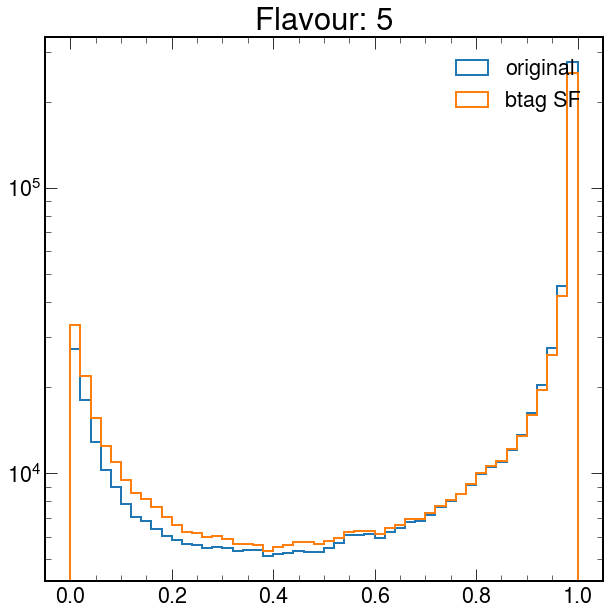

In [106]:
for fl in [0,4,5]:
    mask = flavour==fl
    plt.hist(discr[mask], range=(0,1), bins=50, histtype="step",linewidth=2, label="original")
    plt.hist(discr[mask], weights=w[mask], range=(0,1), bins=50, linewidth=2,histtype="step", label="btag SF")
    plt.title(f"Flavour: {fl}")
    plt.legend()
    plt.yscale("log")
    plt.show()

## Overall normalization pre/post btagSF

Text(1, 0, 'Inclusive N. jets')

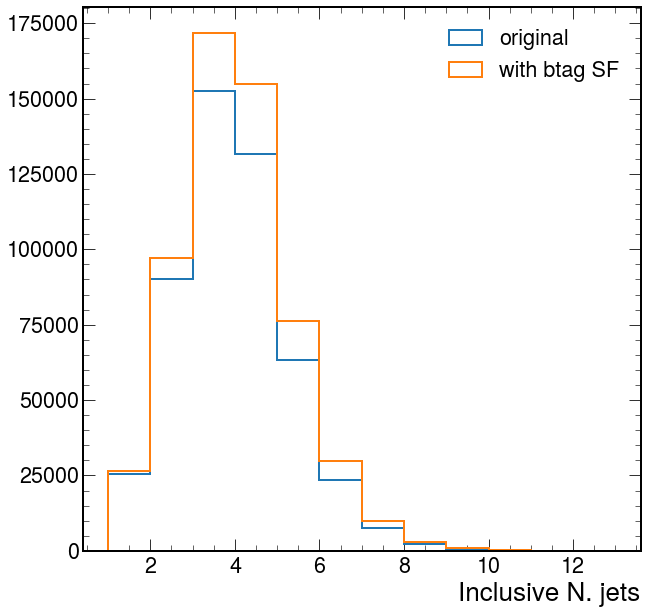

In [116]:
H, *_ = plt.hist(njet, bins=12, range=(1, 13),histtype="step", label="original", linewidth=2)
Hsf, *_  = plt.hist(njet, weights=event_weight, bins=12, range=(1, 13),histtype="step", label="with btag SF", linewidth=2)
plt.legend()
plt.xlabel("Inclusive N. jets" )

In [127]:
import hist

In [156]:
H = (hist.Hist.new
     .StrCat(["original", "btagSF"], name="version")
    .Reg(9, 1, 10, name="njet")
    .Weight())

In [157]:
H.fill(version="original", njet=njet)
H.fill(version="btagSF", njet=njet, weight=event_weight)

Hist(
  StrCategory(['original', 'btagSF'], name='version', label='version'),
  Regular(9, 1, 10, name='njet', label='njet'),
  storage=Weight()) # Sum: WeightedSum(value=1.06616e+06, variance=1.20249e+06) (WeightedSum(value=1.07274e+06, variance=1.20936e+06) with flow)

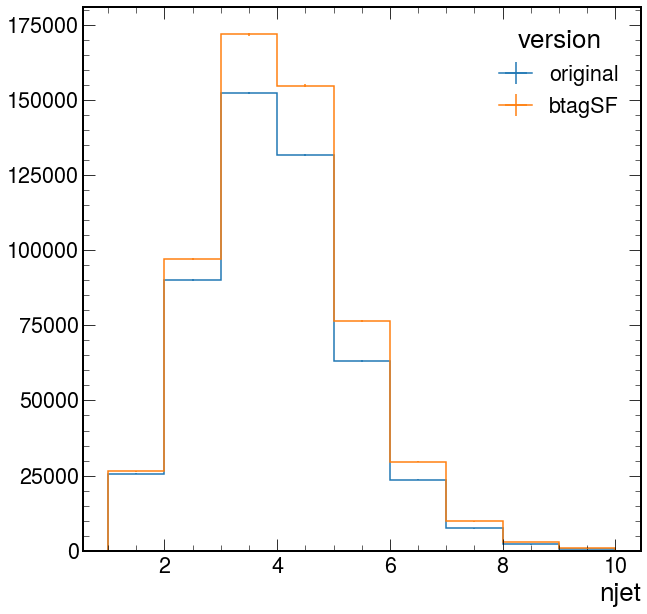

In [158]:
fig, ax = plt.subplots()
H[:, :].plot1d(ax=ax)
ax.legend(title="version")

In [159]:
num = H["original",:].values()
denom = H["btagSF", :].values()
sf = np.where(
    (num>0)&(denom>0), 
    num / denom, 
    1.0)
#

In [160]:
sfhist = hist.Hist(*H.axes[1:], data=sf)

Our SF is now an histogram and we can use it to convert it to correctionlib

In [161]:
sfhist

Hist(Regular(9, 1, 10, name='njet', label='njet'), storage=Double()) # Sum: 7.464676969939082

In [41]:
H.axes

(StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2btag', '3btag', 'btagSF', 'no_btagSF'], growth=True, name='cat', label='Cat'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Regular(25, 0, 25, name='njet', label='$N_{jet}$'))

In [68]:
import correctionlib, rich
import correctionlib.convert

In [165]:
# without a name, the resulting object will fail validation
sfhist.name = "btagSF_norm_correction"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "SF to correct the overall normalization after the application of btagSF weights"
# set overflow bins behavior (default is to raise an error when out of bounds)
clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="btagSF normalization corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("/work/dvalsecc/ttHbb/PocketCoffea/notebooks/mycorrections_test.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
btagSF normalization corrections
📂
└── 📈 btagSF_norm_correction (v0)
    SF to correct the overall normalization after the application of btagSF weights
    Node counts: Binning: 1
    ╭──────────── ▶ input ────────────╮
    │ njet (real)                     │
    │ njet                            │
    │ Range: [1.0, 10.0), overflow ok │
    ╰─────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

In [166]:
ceval = cset.to_evaluator()

In [172]:
ceval['btagSF_norm_correction'].evaluate(np.array([1,2,3,4,4,4,5,56,9,10, 0, -1]))

array([0.96640931, 0.92905519, 0.88723484, 0.85111607, 0.85111607,
       0.85111607, 0.82725979, 0.70738233, 0.70738233, 0.70738233,
       0.96640931, 0.96640931])

# Full 2018 output

In [100]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v40/output.coffea" 
output = load(filename1)
print(output.keys())

H = output["hist_njet"].to_hist()

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht_bins1', 'hist2d_Njet_Ht_bins2', 'hist2d_Njet_Ht_bins3', 'scale_genweight'])


/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


In [77]:
H

Hist(
  StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
  StrCategory(['2b', '2b_btagSF', '3b', '3b_btagSF', 'btagSF', 'btagSF_calib', 'no_btagSF'], growth=True, name='cat', label='Cat'),
  StrCategory(['2018'], growth=True, name='year', label='Year'),
  Regular(25, 0, 25, name='njet', label='$N_{jet}$'),
  storage=Weight()) # Sum: WeightedSum(value=1.22436e+07, variance=582543)

Text(0.5, 0.98, 'TTToSemileptonic')

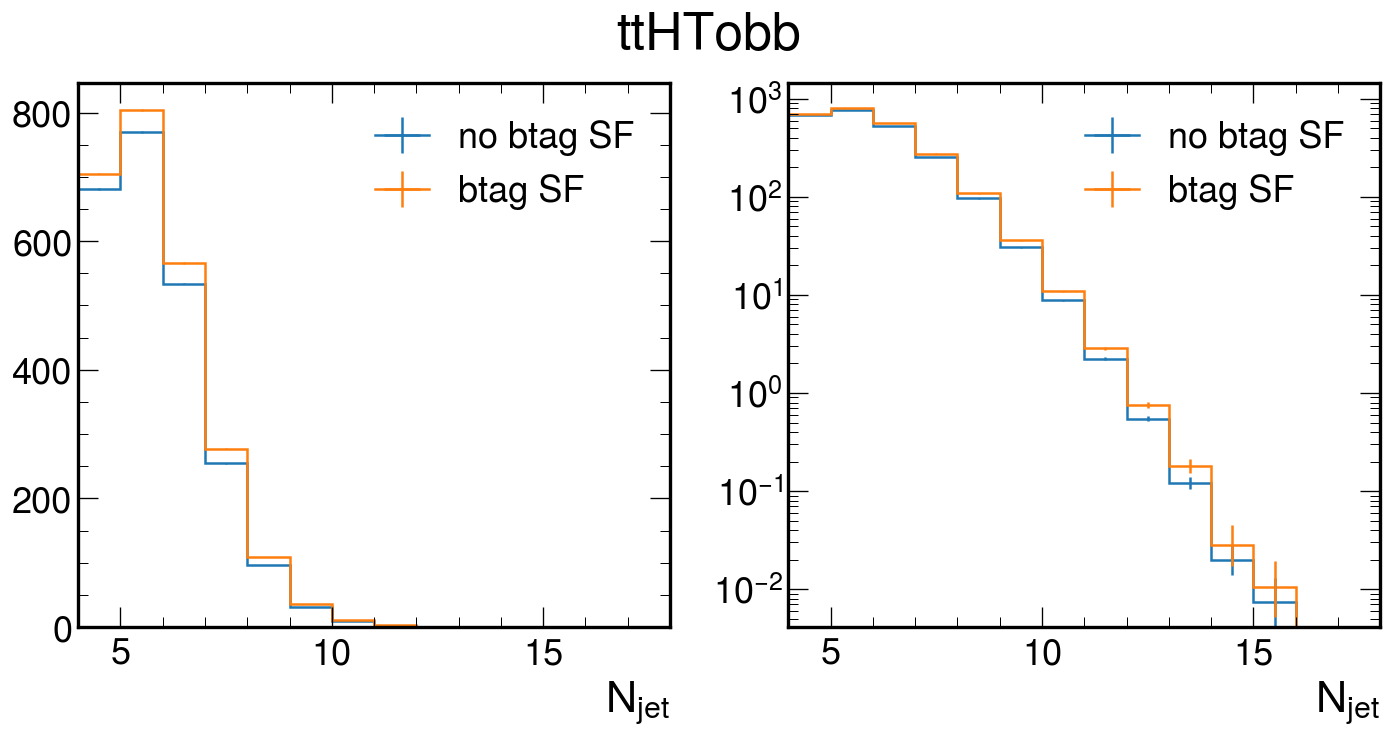

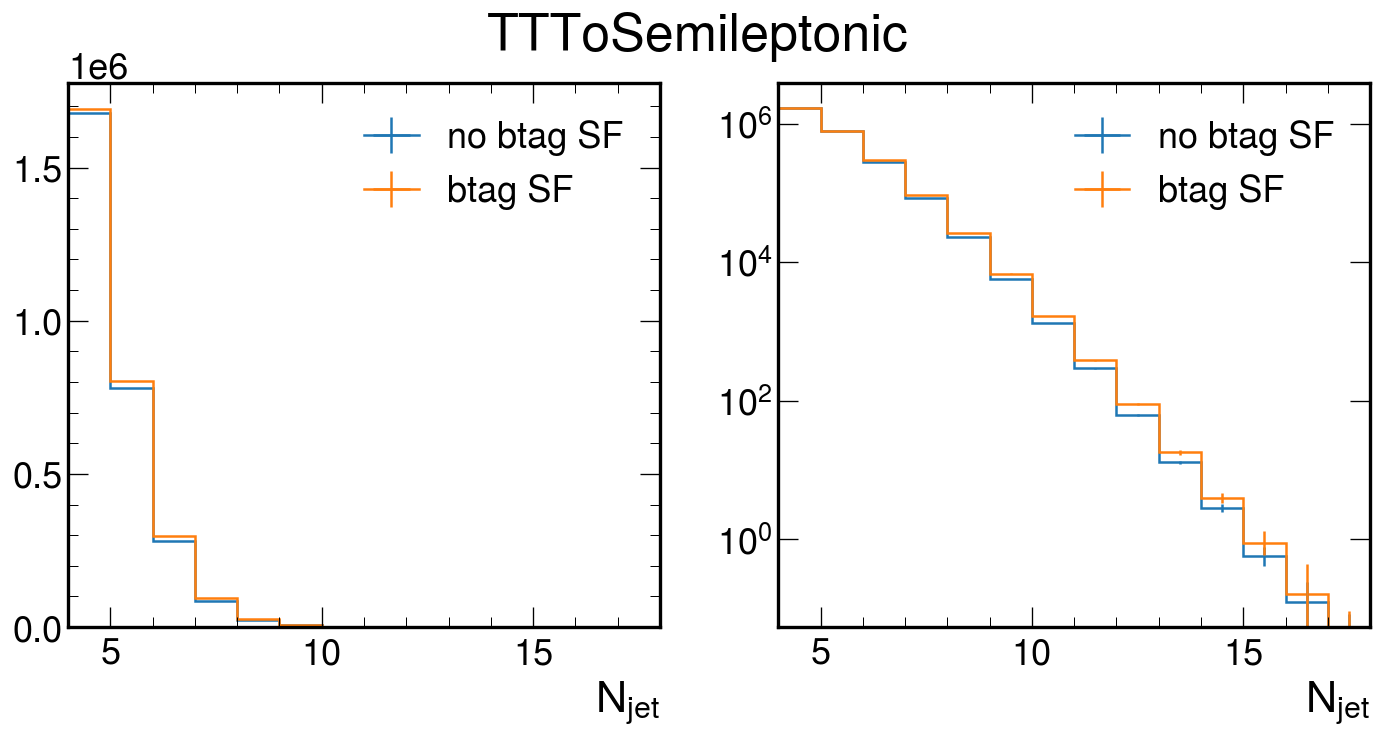

In [61]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()
ax.set_xlim(4,18)

hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
ay.set_xlim(4,18)

fig.suptitle("ttHTobb")

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()
ax.set_xlim(4,18)

hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
ay.set_xlim(4,18)

fig.suptitle("TTToSemileptonic")

# Try to create a correctionlib with multiple categories

In [6]:
num = H[:,"no_btagSF",:,:].values()
denom = H[: , "btagSF",:,:].values()

In [7]:
sf = np.where(  (num>0)&(denom>0), num/denom, 1.0)

/tmp/ipykernel_61368/2570729222.py:1: RuntimeWarning: invalid value encountered in true_divide
  sf = np.where(  (num>0)&(denom>0), num/denom, 1.0)


In [8]:
import hist
sfhist = hist.Hist(H.axes[0],H.axes[2],H.axes[3], data=sf)

In [9]:
sfhist["ttHTobb",'2018',:].values()

array([1.        , 1.        , 1.        , 1.        , 0.96597233,
       0.95729766, 0.9433591 , 0.91900112, 0.88582703, 0.84970417,
       0.80895186, 0.78044002, 0.72922368, 0.66602761, 0.69838301,
       0.70018798, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [10]:
[ax for i, ax in enumerate(sfhist.axes)]

[StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Regular(25, 0, 25, name='njet', label='$N_{jet}$')]

In [12]:
import correctionlib, rich
import correctionlib.convert
# without a name, the resulting object will fail validation
sfhist.name = "btagSF_norm_correction"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "SF to correct the overall normalization after the application of btagSF weights"
# set overflow bins behavior (default is to raise an error when out of bounds)
#clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="btagSF normalization corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("/work/dvalsecc/ttHbb/PocketCoffea/notebooks/btagSF_norm.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
btagSF normalization corrections
📂
└── 📈 btagSF_norm_correction (v0)
    SF to correct the overall normalization after the application of btagSF weights
    Node counts: Category: 3, Binning: 2
    ╭───────────── ▶ input ─────────────╮ ╭─── ▶ input ───╮ ╭───── ▶ input ──────╮
    │ sample (string)                   │ │ year (string) │ │ njet (real)        │
    │ Sample                            │ │ Year          │ │ $N_{jet}$          │
    │ Values: TTToSemiLeptonic, ttHTobb │ │ Values: 2018  │ │ Range: [0.0, 25.0) │
    ╰───────────────────────────────────╯ ╰───────────────╯ ╰────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

# Comparison plots

Text(0.5, 0.98, 'TTToSemileptonic')

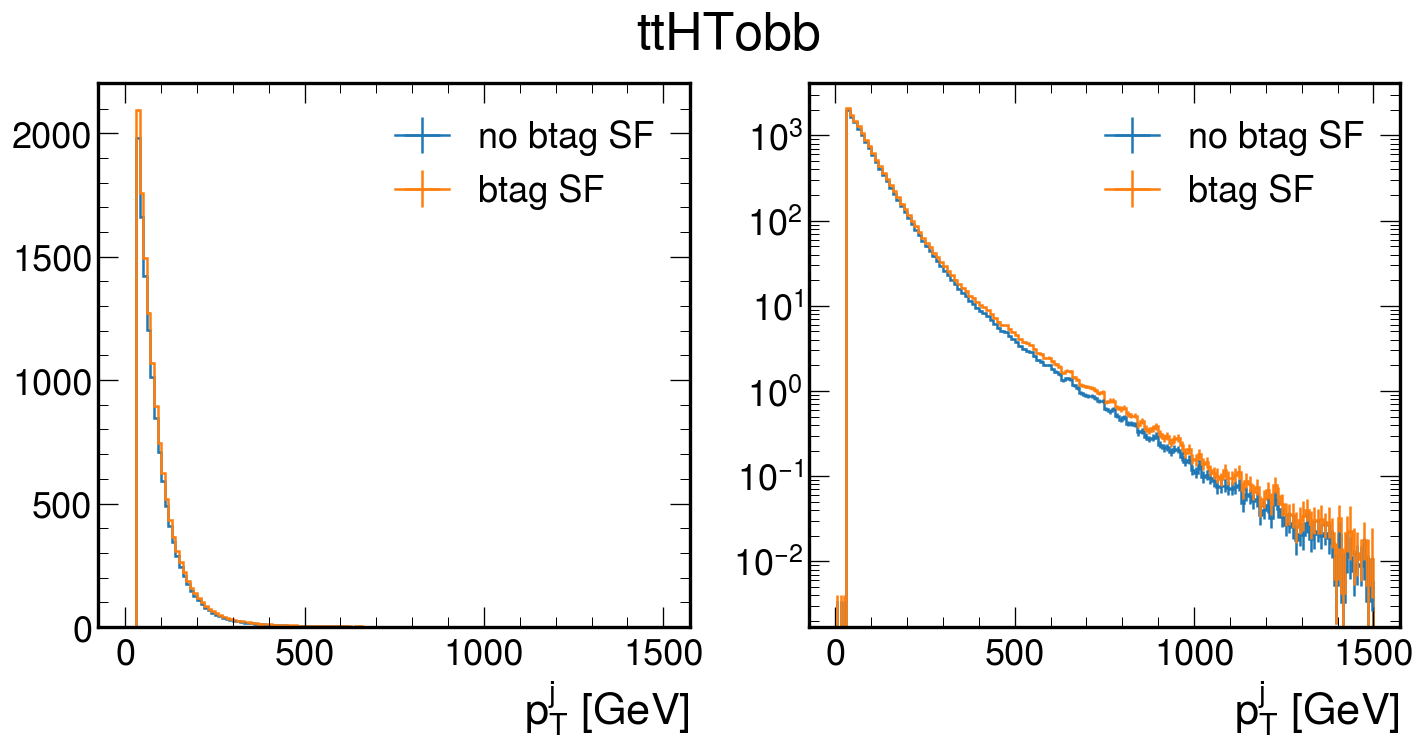

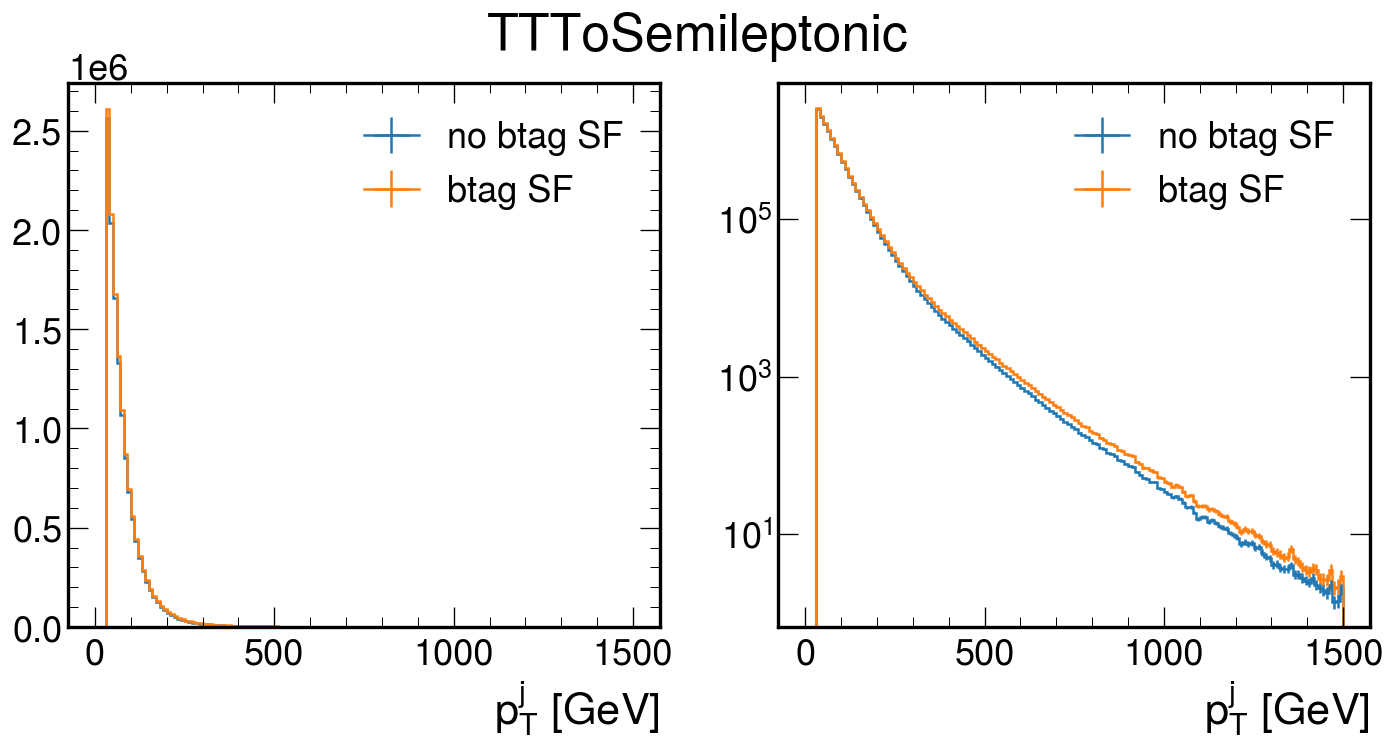

In [67]:
H = output["hist_jet_pt"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")

fig.suptitle("ttHTobb")

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
fig.suptitle("TTToSemileptonic")

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


Text(0.5, 0.98, 'TTToSemileptonic')

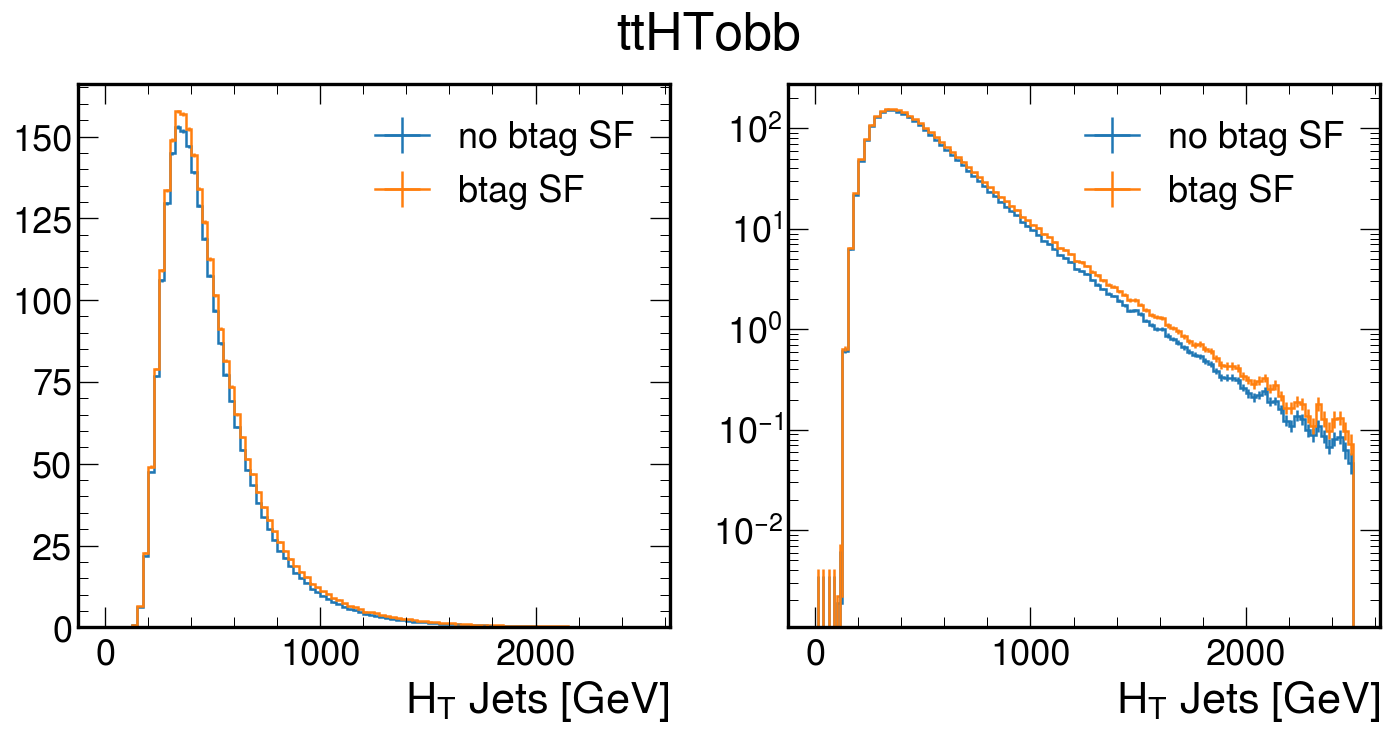

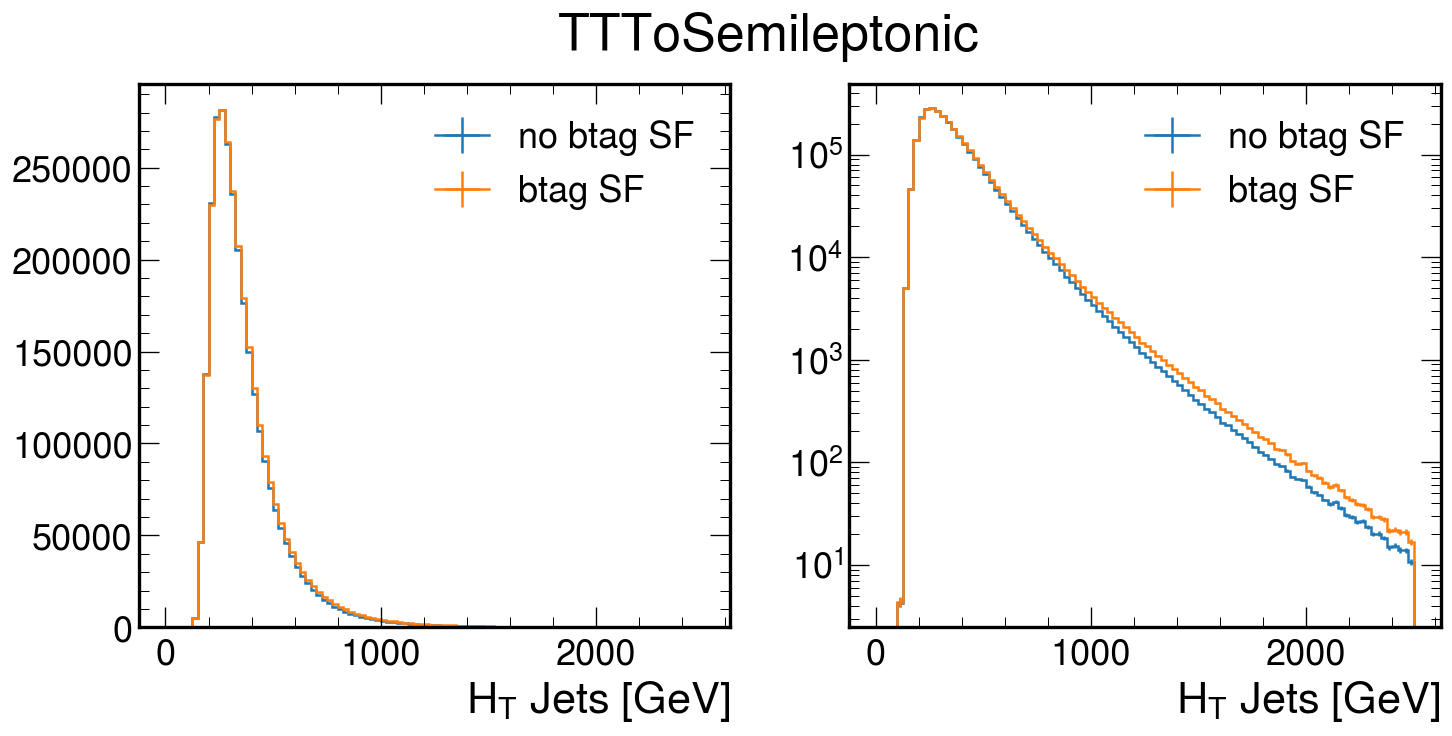

In [30]:
H = output["hist_Ht"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["ttHTobb",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["ttHTobb",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")

fig.suptitle("ttHTobb")

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ax)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ax)
ax.legend()

hep.histplot(H["TTToSemiLeptonic",  "no_btagSF",'2018',:], label="no btag SF", ax=ay)
hep.histplot(H["TTToSemiLeptonic",  "btagSF",'2018',:], label="btag SF", ax=ay)
ay.legend()
ay.set_yscale("log")
fig.suptitle("TTToSemileptonic")

## Ratio plots

In [141]:
def hist_comparison(df, var, shapes,ylog=False, output_folder=None, ):
    '''
    shapes = [ (sample,cat,year, label),] 
    '''
    # os.makedirs(output_folder, exist_ok=True)
    # os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_folder}")
    
    H = df[var].to_hist()
    mmax = np.max(H.values())
    fig = plt.figure(figsize=(8,9), dpi=100)
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    plt.subplots_adjust(wspace=0.3)
    
    axu =  axs[0]
    axd =  axs[1]

    for sample, cat, year, label in shapes:
        hep.histplot(H[sample, cat,year,:], label=label, ax=axu)
        
    if ylog:
        axu.set_yscale("log")
    axu.legend()
    axu.set_xlabel('')
    axu.set_ylabel('Events')
    hep.plot.ylow(axu)
    hep.plot.yscale_legend(axu)

    # Ratios
    sample, cat, year, label = shapes[0]
    nom = H[sample,cat,year,:]
    nomvalues = nom.values()
    centers = nom.axes[0].centers
    edges = nom.axes[0].edges
    minratio, maxratio = 1000.,0.
    for  sample, cat, year, label in shapes[:]:
        h = H[sample,cat,year,:]
        r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
        m, M = np.min(r), np.max(r)
        if m < minratio: minratio = m
        if M > maxratio: maxratio = M
        axd.errorbar(centers, r, xerr=0, yerr=0, label=label,
                     fmt=".", linestyle='none', elinewidth=1)
       
    axd.legend(ncol=3, fontsize='xx-small')
    hep.plot.yscale_legend(axd)
    axd.set_xlabel(nom.axes[0].label)
    axd.set_ylim(0.8*minratio, 1.2*maxratio)
    axd.set_ylabel("ratio")
    axd.grid(which="both",axis="y")
    

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axu) 
    

/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


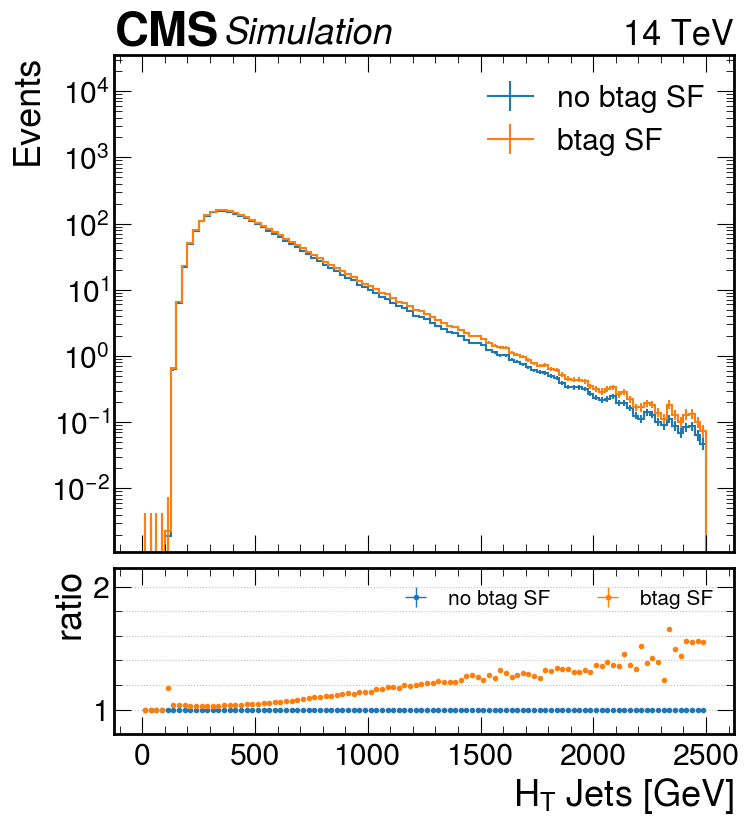

In [79]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


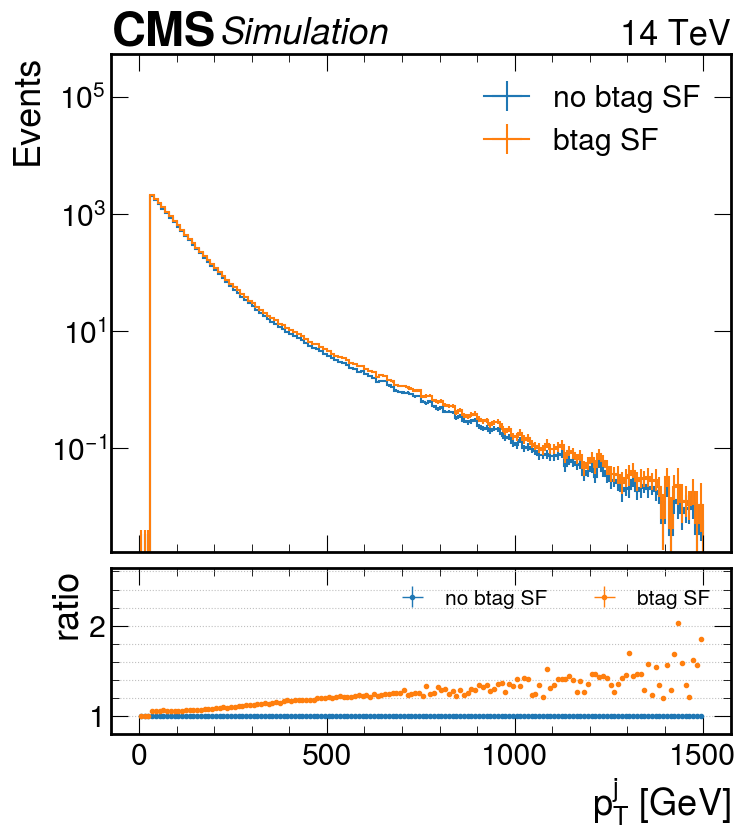

In [80]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


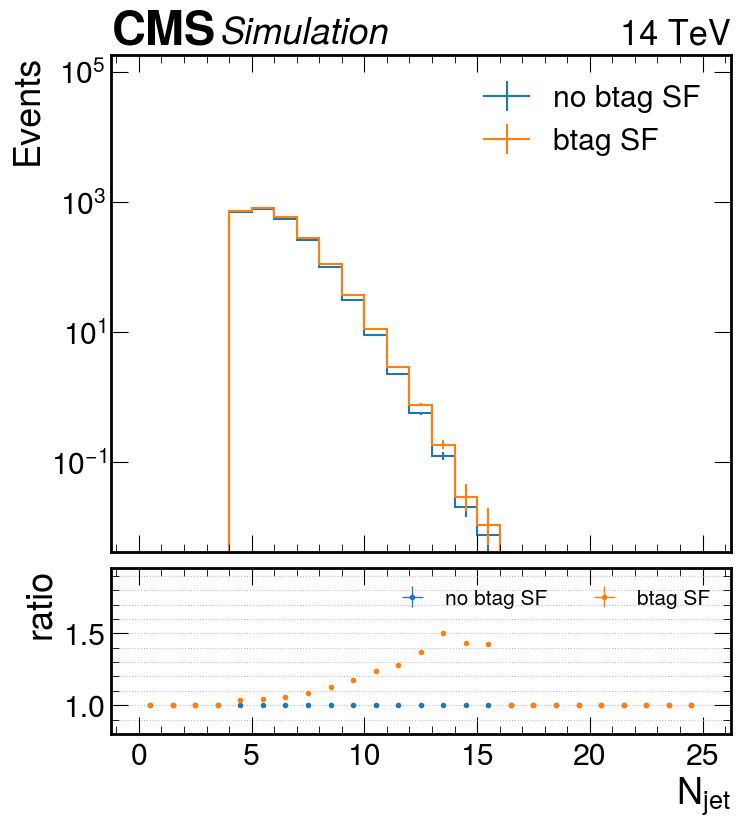

In [98]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


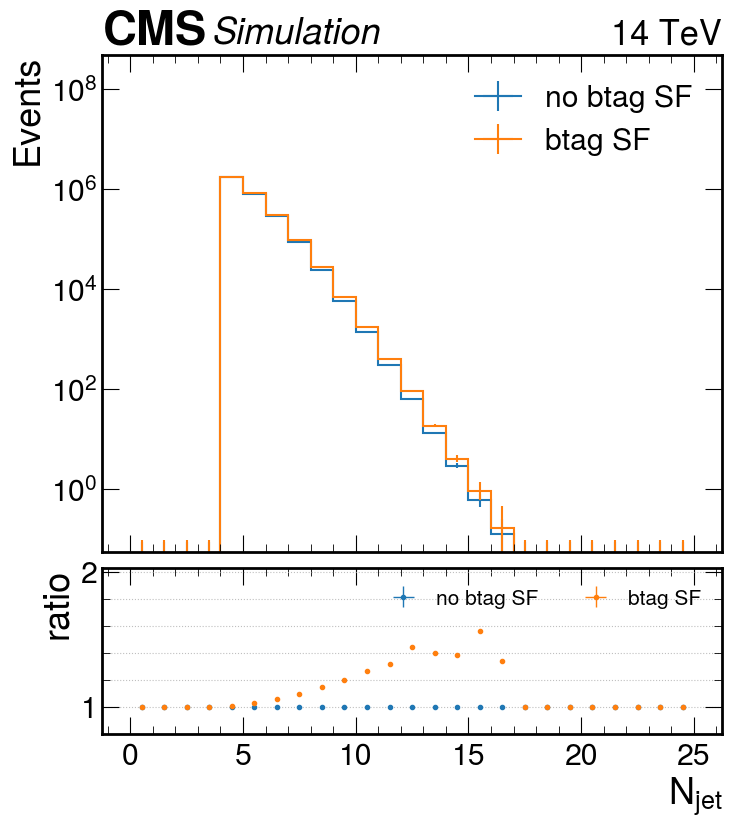

In [99]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


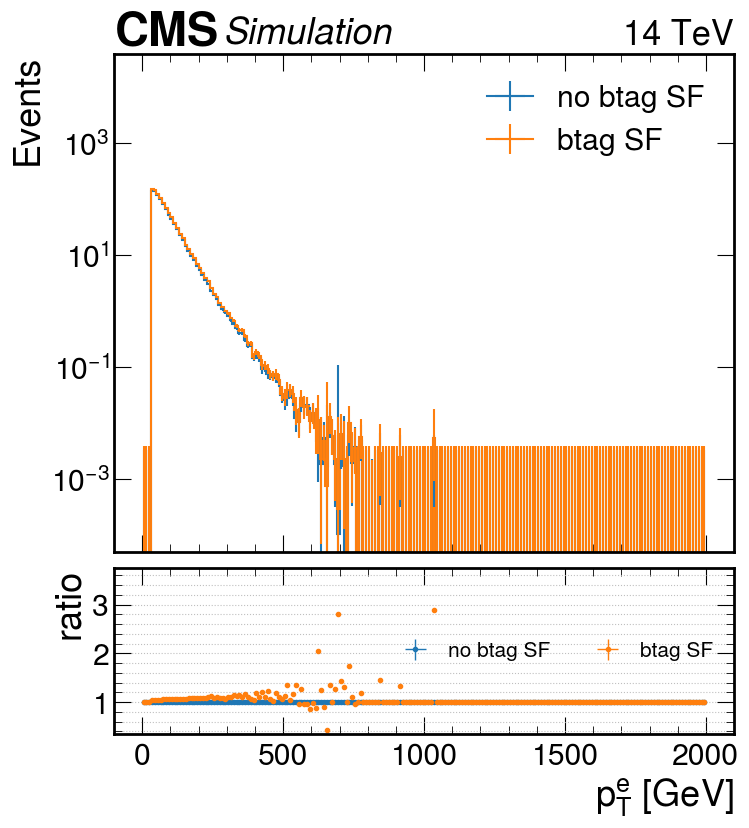

In [84]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_electron_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


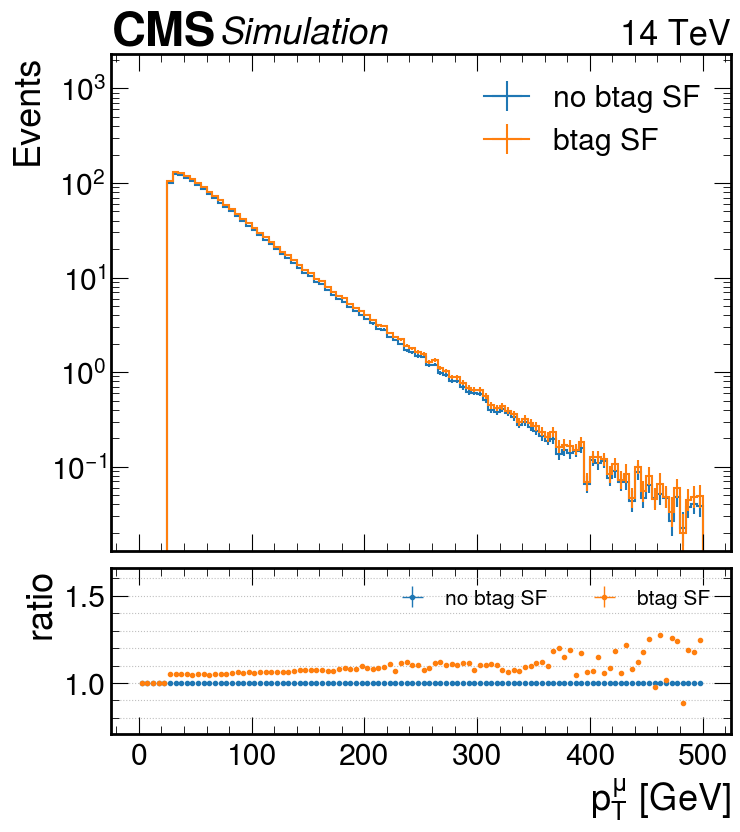

In [85]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_muon_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


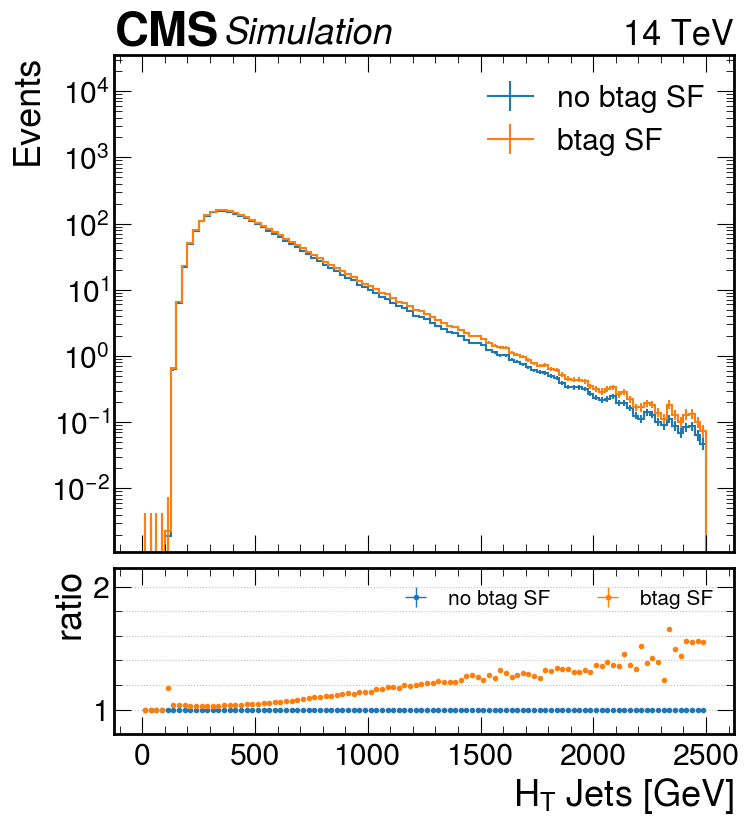

In [86]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


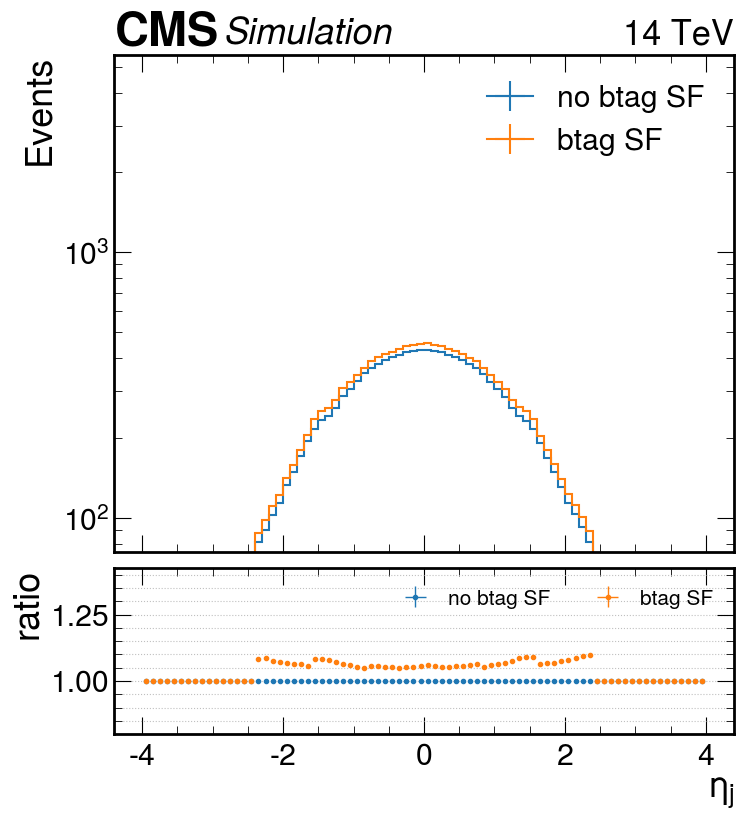

In [87]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

# 2D SF with Jet $H_T$ and $N_{jets}$

Text(0.5, 1.0, 'btagSF')

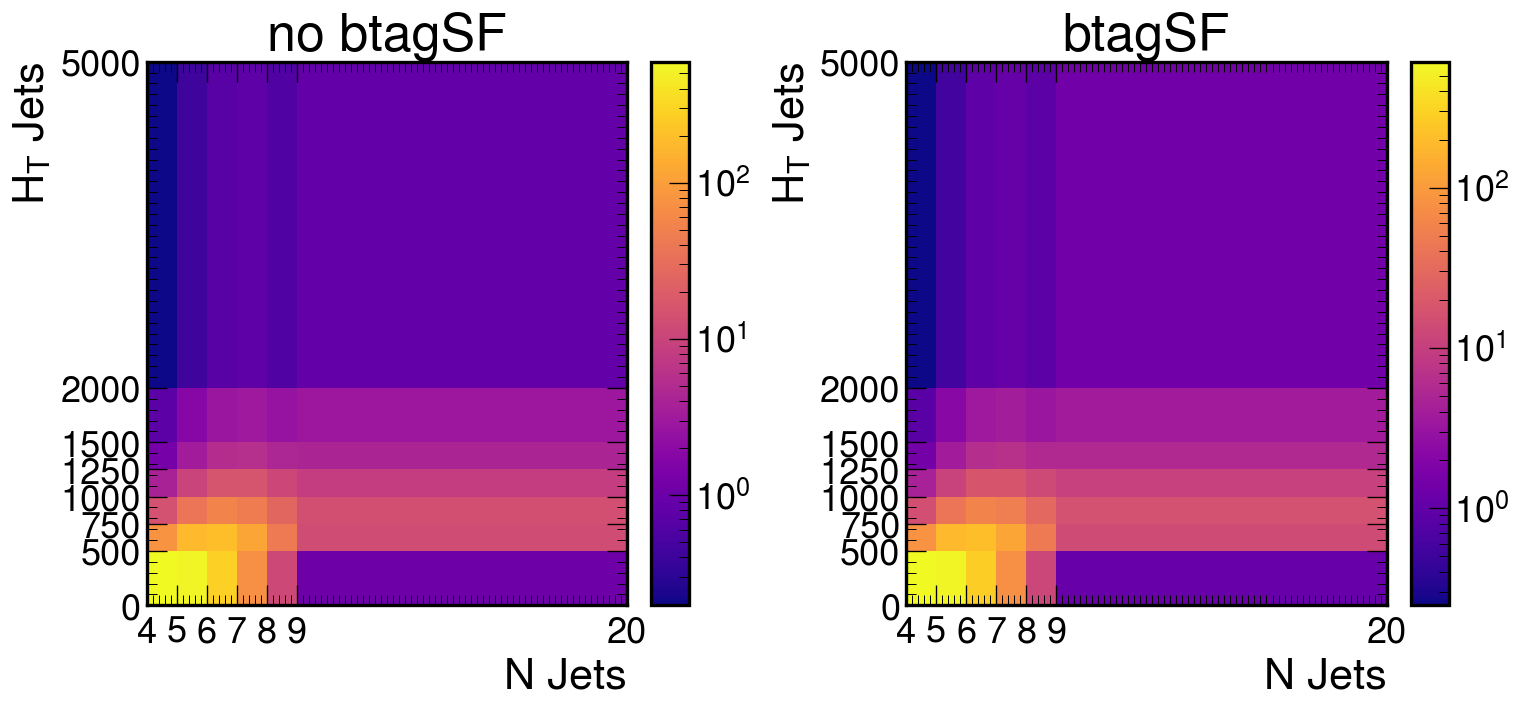

In [101]:
A = output["hist2d_Njet_Ht_bins1"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
plt.subplots_adjust(wspace=0.4)
hep.hist2dplot(A['ttHTobb','no_btagSF','2018',:,:], cmap="plasma", ax=ax, cmin=0.001, norm=LogNorm())
ax.set_title("no btagSF")
hep.hist2dplot(A['ttHTobb','btagSF','2018',:
                 ,:], cmap="plasma", ax=ay, cmin=0.001,norm=LogNorm())
ay.set_title("btagSF")

Text(0.5, 1.0, 'btagSF')

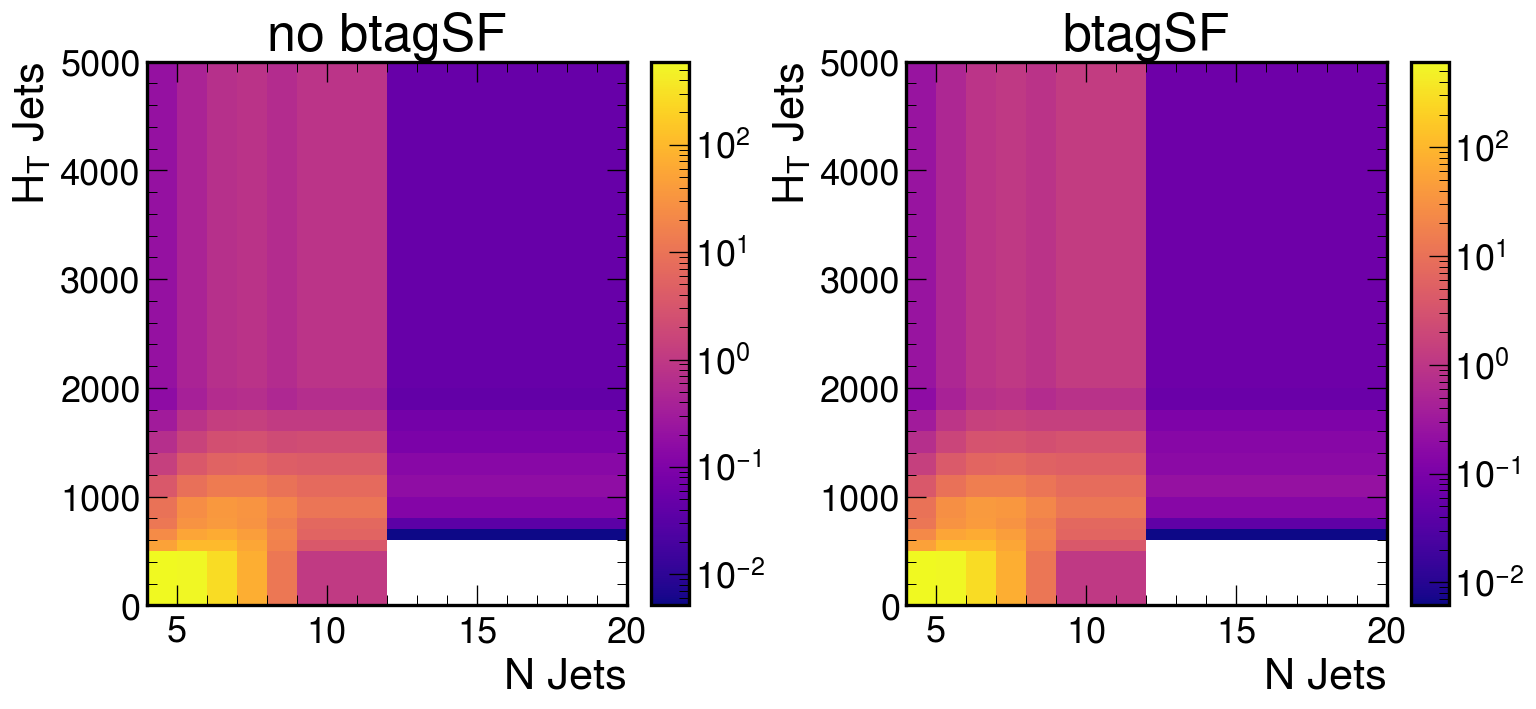

In [102]:
A = output["hist2d_Njet_Ht_bins2"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
plt.subplots_adjust(wspace=0.4)
hep.hist2dplot(A['ttHTobb','no_btagSF','2018',:,:], cmap="plasma", ax=ax, cmin=0.001, norm=LogNorm())
ax.set_title("no btagSF")
hep.hist2dplot(A['ttHTobb','btagSF','2018',:
                 ,:], cmap="plasma", ax=ay, cmin=0.001,norm=LogNorm())
ay.set_title("btagSF")

Text(0.5, 1.0, 'btagSF')

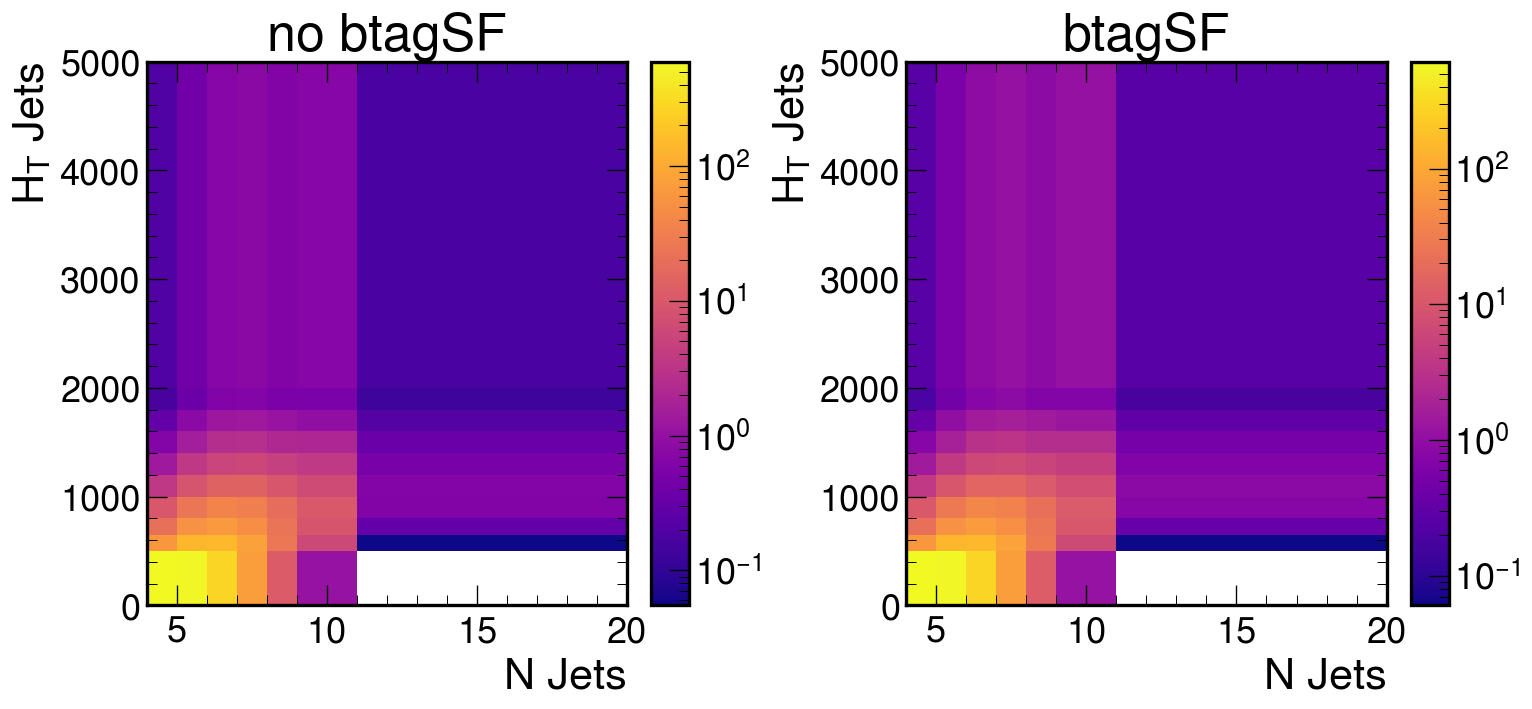

In [103]:
A = output["hist2d_Njet_Ht_bins3"].to_hist()

fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)
plt.subplots_adjust(wspace=0.4)
hep.hist2dplot(A['ttHTobb','no_btagSF','2018',:,:], cmap="plasma", ax=ax, cmin=0.001, norm=LogNorm())
ax.set_title("no btagSF")
hep.hist2dplot(A['ttHTobb','btagSF','2018',:
                 ,:], cmap="plasma", ax=ay, cmin=0.001,norm=LogNorm())
ay.set_title("btagSF")

/tmp/ipykernel_51161/359820697.py:10: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/359820697.py:12: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/359820697.py:12: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/359820697.py:12: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


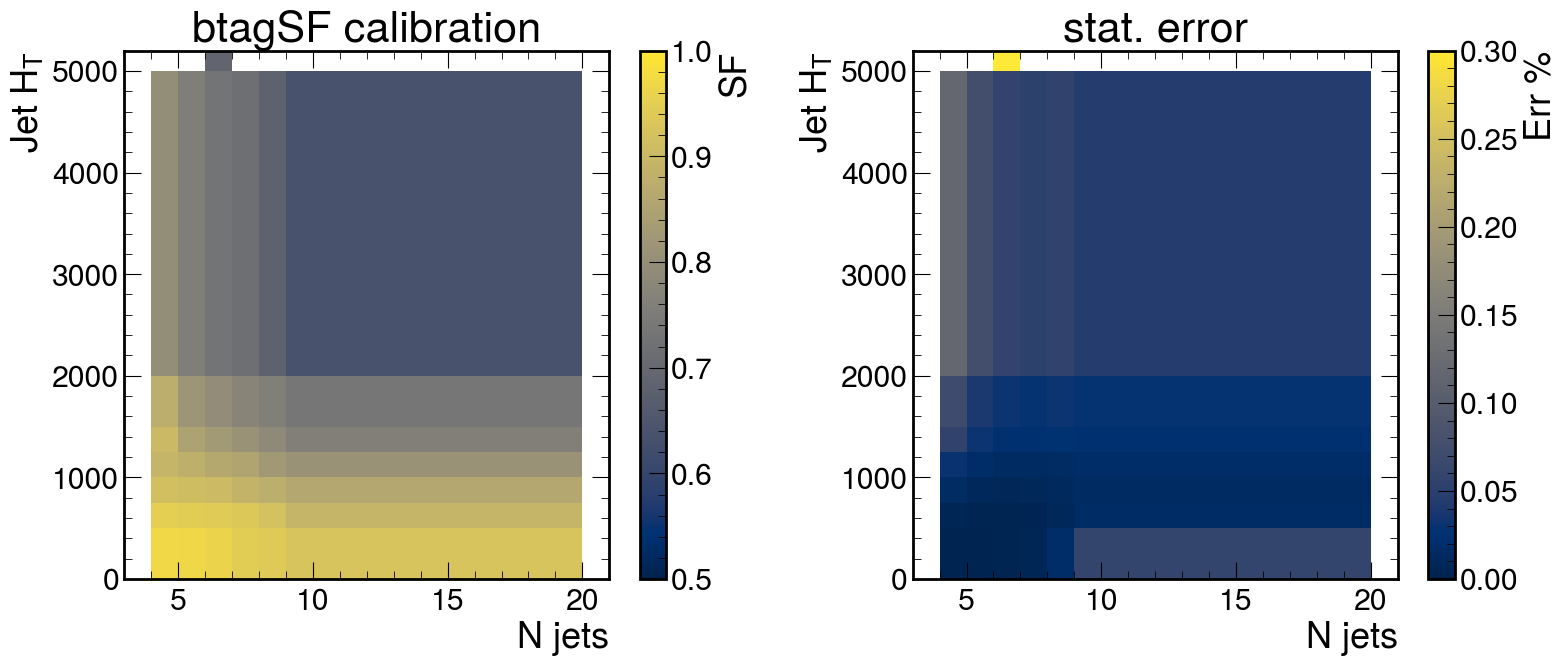

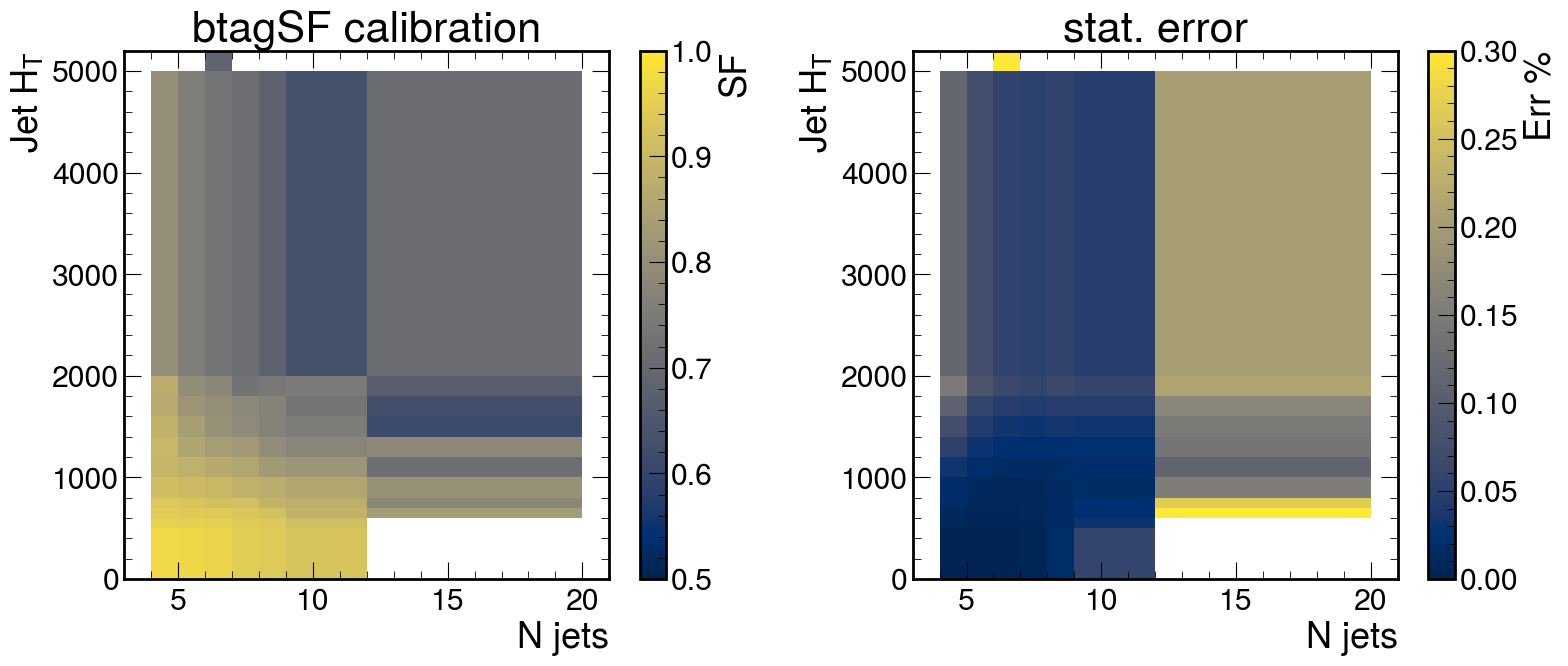

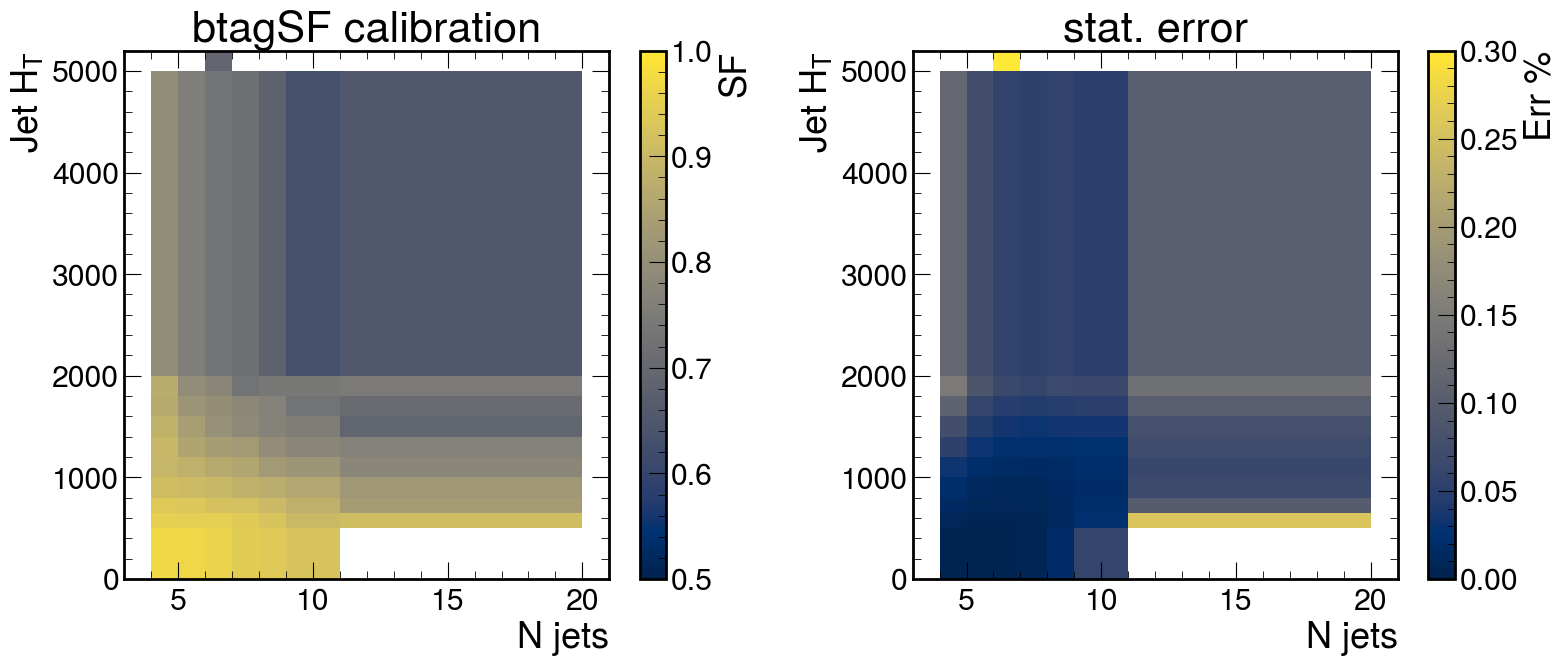

In [104]:
for i in ["bins1","bins2","bins3"]:

    A = output["hist2d_Njet_Ht_"+i].to_hist()

    w_num, x, y = A['ttHTobb','no_btagSF','2018',:,:].to_numpy(flow=True)
    num_var = A['ttHTobb','no_btagSF','2018',:,:].variances(flow=True)
    w_denom, x, y = A['ttHTobb','btagSF','2018',:,:].to_numpy(flow=True)
    denom_var = A['ttHTobb','btagSF','2018',:,:].variances(flow=True)

    ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
    ratio_err =  np.where( (w_denom>0)&(w_num>0),
                          np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                          0.)

    x_plot = x
    y_plot = y
    x_plot[-1] = x_plot[-2]+1
    y_plot[-1] = y_plot[-2]+200
    x_plot[0] = x_plot[1]-1 
    y_plot[0] = -1

    fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
    plt.subplots_adjust(wspace=0.3)

    ax.set_title("btagSF calibration")
    I = ax.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio.T, ratio.T==1.),vmax=1, vmin=0.5, cmap="cividis")
    plt.colorbar(I, ax=ax, label="SF")
    ax.set_xlabel("N jets")
    ax.set_ylabel("Jet $H_T$")

    ay.set_title("stat. error")
    I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.3, vmin=0, cmap="cividis")
    plt.colorbar(I, ax=ay, label="Err %")
    ay.set_xlabel("N jets")
    ay.set_ylabel("Jet $H_T$")

In [8]:
h.axes

(StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2btag', '3btag', 'btagSF', 'no_btagSF'], growth=True, name='cat', label='Cat'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Variable([4, 5, 6, 7, 8, 9, 17], name='Njet', label='N Jets'),
 Variable([0, 500, 750, 1000, 1250, 1500, 2000], name='Ht', label='$H_T$ Jets'))

In [9]:
h = A
sfhist = hist.Hist(h.axes[0],h.axes[2],h.axes[3], data=ratio)

TypeError: label must be a string

# Correctionlib for systematics

In [118]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v40/output.coffea" 
output = load(filename1)
output.keys()

A = output["hist2d_Njet_Ht_bins3"].to_hist()

In [119]:
w_num,  _,_, x, y = A[:,'no_btagSF',:,:,:].to_numpy(flow=True)
num_var = A[:,'no_btagSF',:,:,:].variances(flow=True)
w_denom,  _,_, x, y = A[:, 'btagSF',:,:,:].to_numpy(flow=True)
denom_var = A[:,'no_btagSF',:,:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)
import hist
sfhist = hist.Hist(A.axes[0],A.axes[2],A.axes[3],A.axes[4], data=ratio)

/tmp/ipykernel_51161/3152328602.py:6: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/3152328602.py:8: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/3152328602.py:8: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/3152328602.py:8: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


In [120]:
sfhist.axes

(StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
 StrCategory(['2018'], growth=True, name='year', label='Year'),
 Variable([4, 5, 6, 7, 8, 9, 11, 20], name='Njet', label='N Jets'),
 Variable([0, 500, 650, 800, 1000, 1200, 1400, 1600, 1800, 2000, 5000], name='Ht', label='$H_T$ Jets'))

In [121]:
sfhist["TTToSemiLeptonic","2018",:,:,]

Hist(
  Variable([4, 5, 6, 7, 8, 9, 11, 20], name='Njet', label='N Jets'),
  Variable([0, 500, 650, 800, 1000, 1200, 1400, 1600, 1800, 2000, 5000], name='Ht', label='$H_T$ Jets'),
  storage=Double()) # Sum: 56.08204335003068 (93.84070326975485 with flow)

In [112]:
import correctionlib, rich
import correctionlib.convert
# without a name, the resulting object will fail validation
sfhist.name = "btagSF_norm_correction"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "SF to correct the overall normalization after the application of btagSF weights"

# set overflow bins behavior (default is to raise an error when out of bounds)

for sample_cat in clibcorr.data.content:
    for year_cat in sample_cat.value.content:
        year_cat.value.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="btagSF normalization corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("/work/dvalsecc/ttHbb/PocketCoffea/PocketCoffea/parameters/btag_SF_calibration/btagSF_calibration_allyears_v2.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
btagSF normalization corrections
📂
└── 📈 btagSF_norm_correction (v0)
    SF to correct the overall normalization after the application of btagSF weights
    Node counts: Category: 3, MultiBinning: 2
    ╭───────────── ▶ input ─────────────╮ ╭───────────── ▶ input ─────────────╮
    │ sample (string)                   │ │ year (string)                     │
    │ Sample                            │ │ Year                              │
    │ Values: TTToSemiLeptonic, ttHTobb │ │ Values: 2018                      │
    ╰───────────────────────────────────╯ ╰───────────────────────────────────╯
    ╭───────────── ▶ input ─────────────╮ ╭───────────── ▶ input ─────────────╮
    │ Njet (real)                       │ │ Ht (real)                         │
    │ N Jets                            │ │ $H_T$ Jets                        │
    │ Range: [4.0, 20.0), overflow ok   │ │ Range: [0.0, 5000.0), overflow ok │
    ╰───────────────────────────────────╯ ╰───────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

## Testing the evaluation

In [113]:
cset = correctionlib.CorrectionSet.from_file("/work/dvalsecc/ttHbb/PocketCoffea/PocketCoffea/parameters/btag_SF_calibration/btagSF_calibration_allyears_v2.json")
corr = cset["btagSF_norm_correction"]

In [114]:
Njet = np.array([4,6,8,9,10])
Ht = np.array([500.,1000.,514.,124.,36.])

In [115]:
corr.evaluate("ttHTobb", "2018",Njet,Ht)

array([0.9519474 , 0.86546484, 0.92600897, 0.92651374, 0.92651374])

# Validation in PocketCoffea

In [126]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v32/output.coffea" 
output = load(filename1)
print(output.keys())

A = output["hist2d_Njet_Ht"].to_hist()

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht', 'scale_genweight'])


/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


In [127]:
A

Hist(
  StrCategory(['TTToSemiLeptonic', 'ttHTobb'], growth=True, name='sample', label='Sample'),
  StrCategory(['2b', '2b_btagSF', '2b_btagSF_calib', '3b', '3b_btagSF', '3b_btagSF_calib', 'btagSF', 'btagSF_calib', 'no_btagSF'], growth=True, name='cat', label='Cat'),
  StrCategory(['2018'], growth=True, name='year', label='Year'),
  Variable([4, 5, 6, 7, 8, 9, 17], name='Njet', label='N Jets'),
  Variable([0, 500, 750, 1000, 1250, 1500, 2000], name='Ht', label='$H_T$ Jets'),
  storage=Weight()) # Sum: WeightedSum(value=1.38922e+07, variance=673772) (WeightedSum(value=1.38969e+07, variance=674061) with flow)

/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


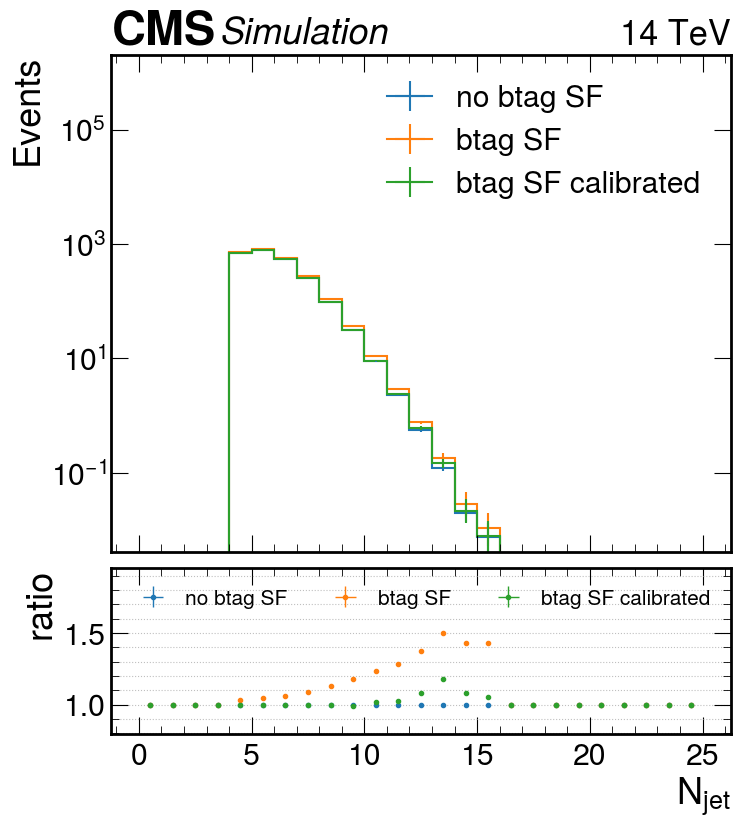

In [128]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


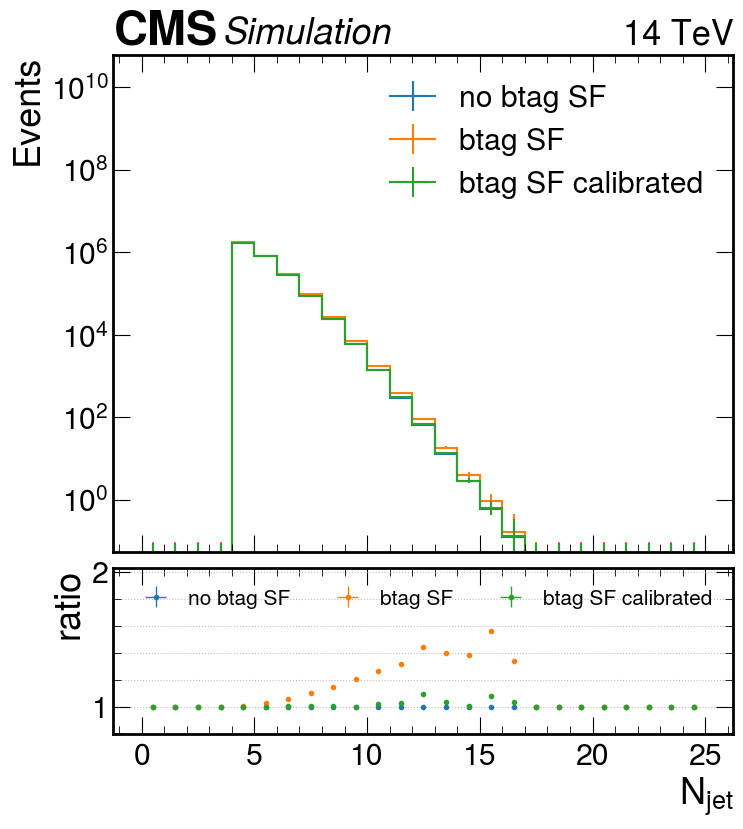

In [64]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


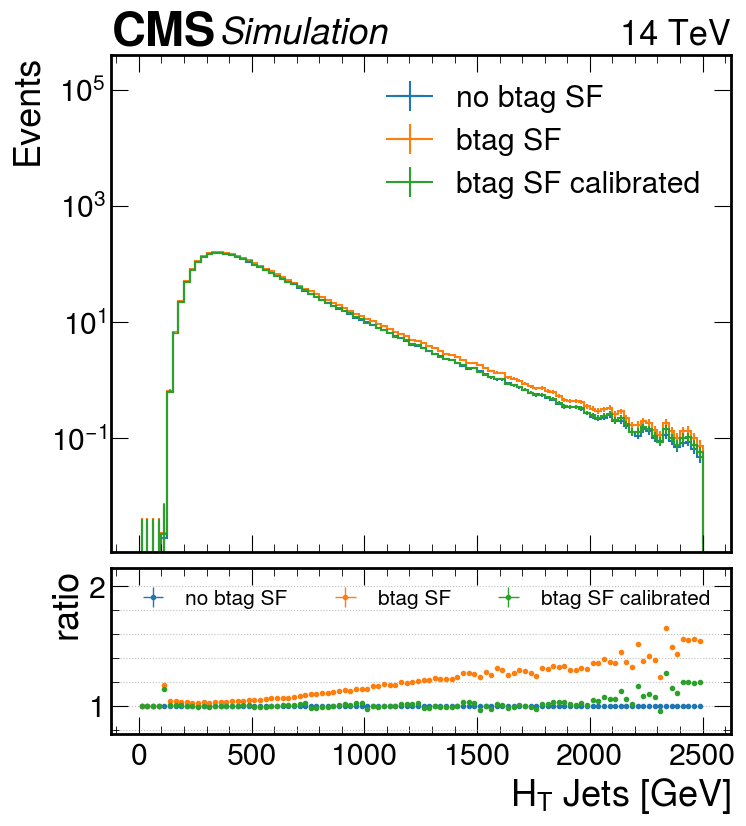

In [65]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


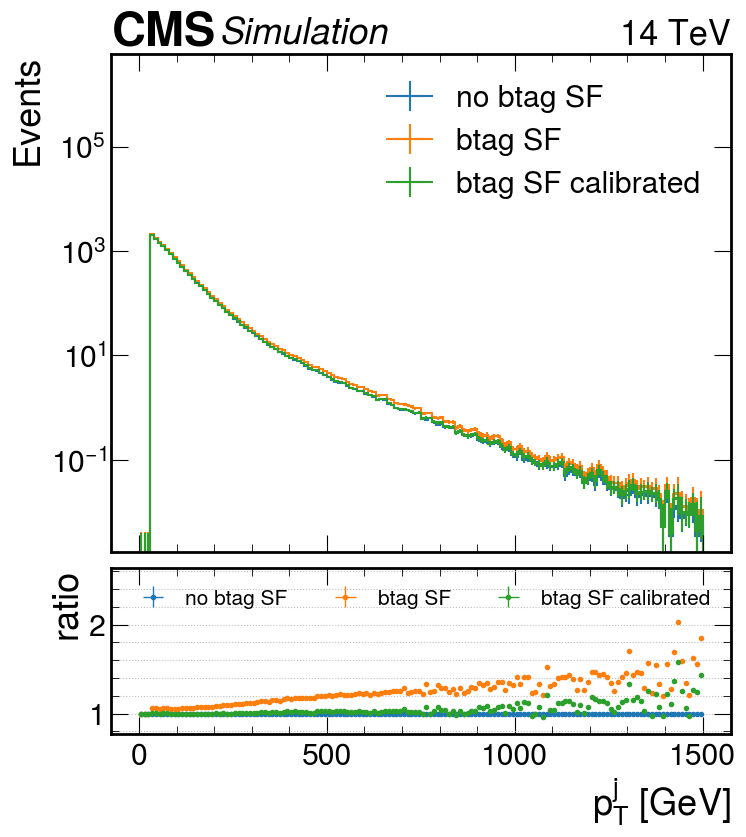

In [66]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


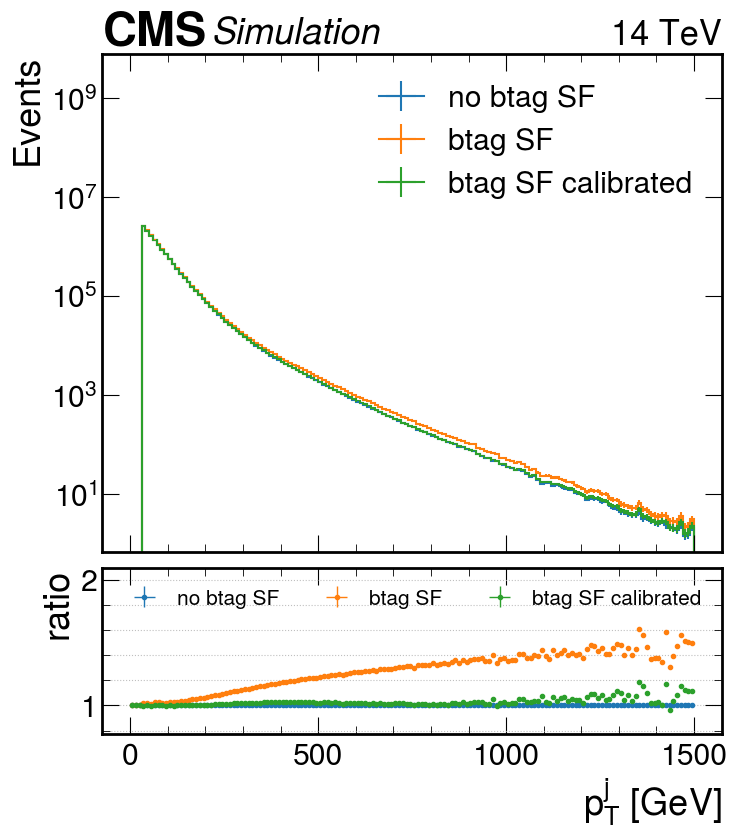

In [67]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


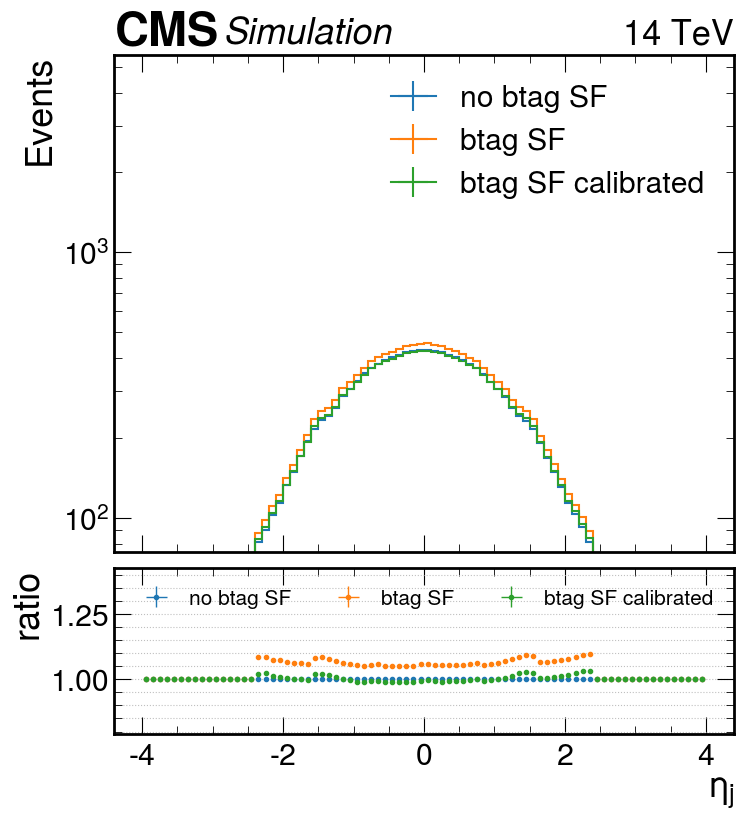

In [68]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/323434774.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


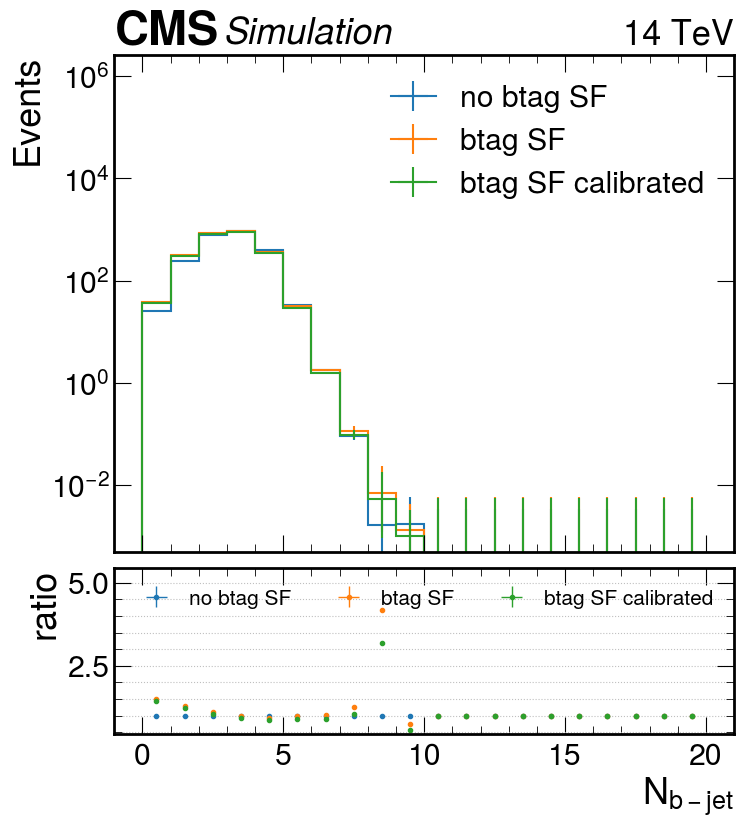

In [71]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_nbjet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


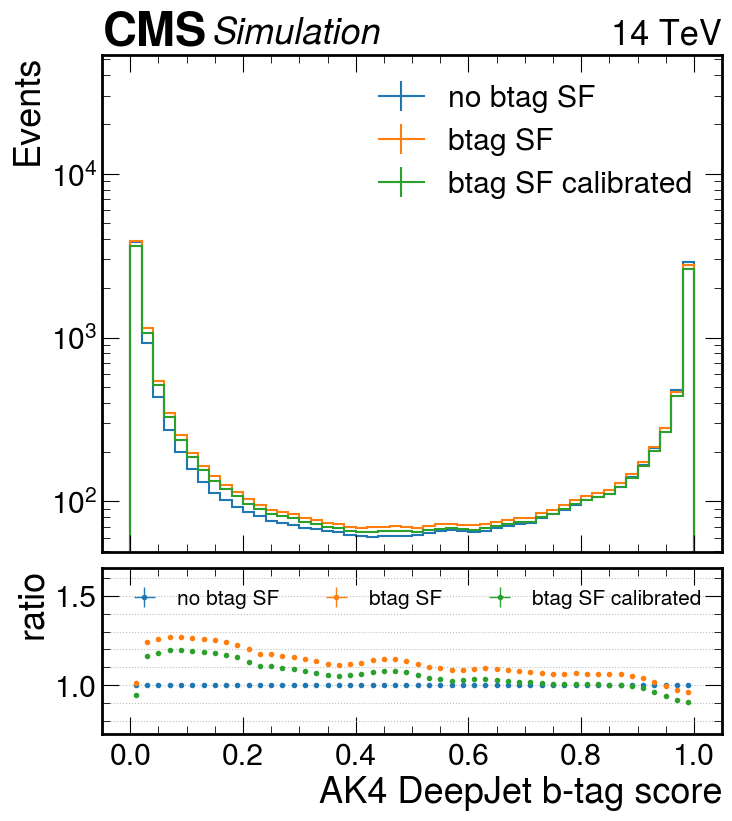

In [69]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


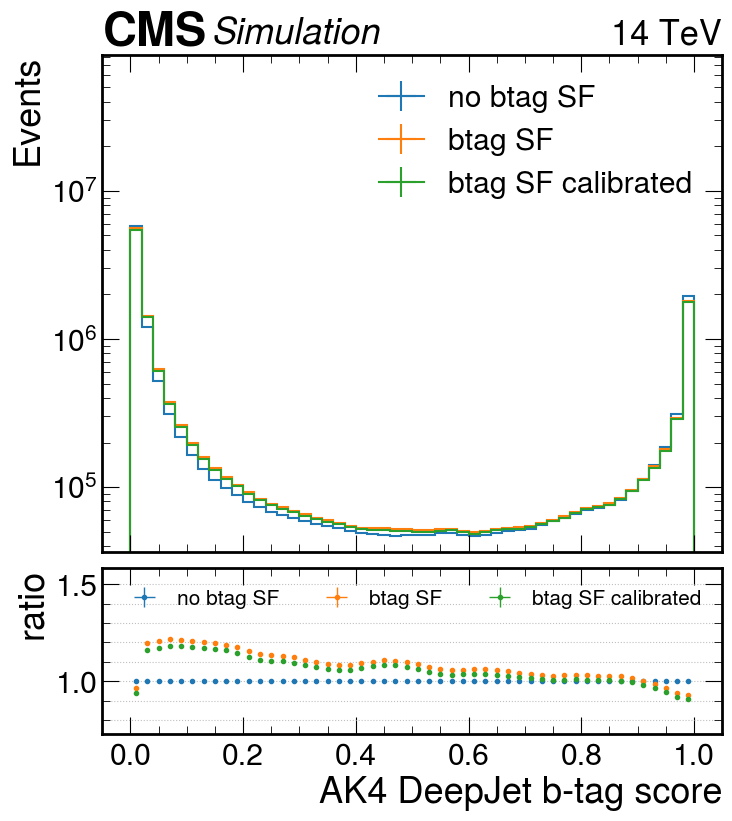

In [70]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

/tmp/ipykernel_51161/2257993790.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/2257993790.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2257993790.py:10: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2257993790.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


Text(0, 1, 'Jet $H_T$')

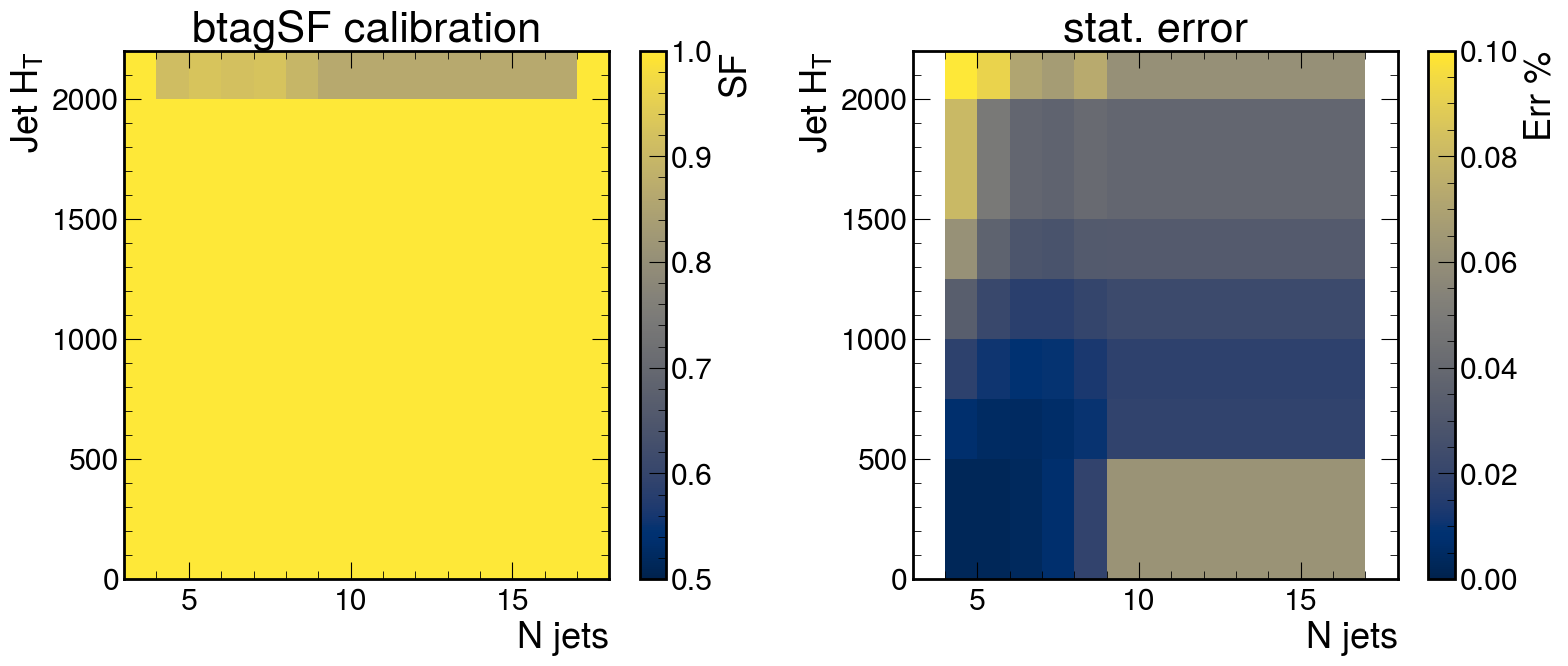

In [59]:
A = output["hist2d_Njet_Ht"].to_hist()

w_num, x, y = A['ttHTobb','no_btagSF','2018',:,:].to_numpy(flow=True)
num_var = A['ttHTobb','no_btagSF','2018',:,:].variances(flow=True)
w_denom, x, y = A['ttHTobb','btagSF_calib','2018',:,:].to_numpy(flow=True)
denom_var = A['ttHTobb','btagSF_calib','2018',:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

x_plot = x
y_plot = y
x_plot[-1] = x_plot[-2]+1
y_plot[-1] = y_plot[-2]+200
x_plot[0] = x_plot[1]-1 
y_plot[0] = -1

fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
plt.subplots_adjust(wspace=0.3)

ax.set_title("btagSF calibration")
I = ax.pcolormesh(x_plot,y_plot, ratio.T,vmax=1, vmin=0.5, cmap="cividis")
plt.colorbar(I, ax=ax, label="SF")
ax.set_xlabel("N jets")
ax.set_ylabel("Jet $H_T$")

ay.set_title("stat. error")
I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.10, vmin=0, cmap="cividis")
plt.colorbar(I, ax=ay, label="Err %")
ay.set_xlabel("N jets")
ay.set_ylabel("Jet $H_T$")

## Validation with correction from smaller bins

In [129]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/btagSF_calibration_v43/output.coffea" 
output = load(filename1)
print(output.keys())


dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_jet_btagDeepFlavB', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_Ht', 'hist2d_Njet_Ht_bins1', 'hist2d_Njet_Ht_bins3', 'scale_genweight'])


/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


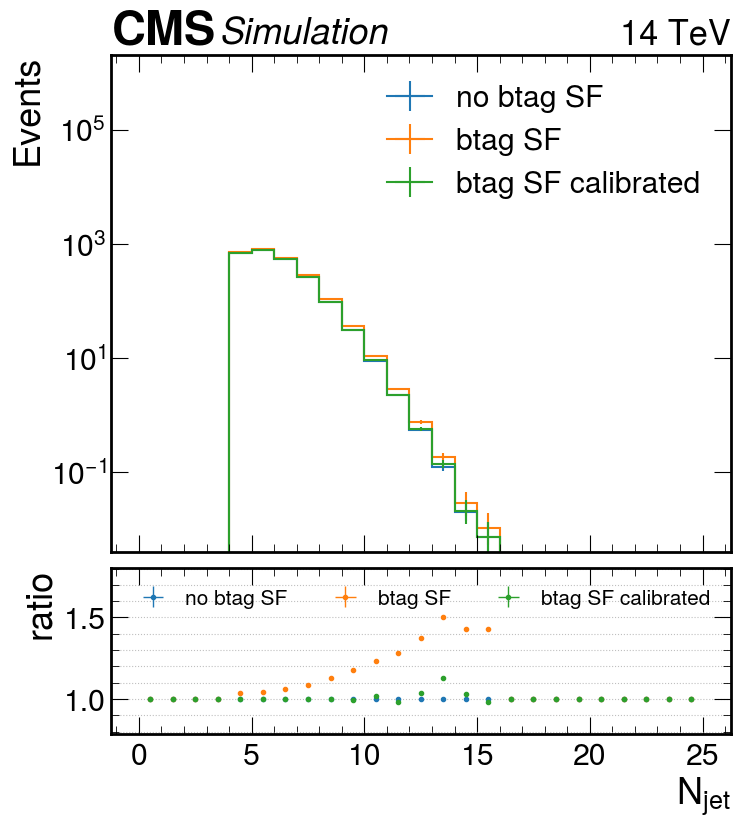

In [142]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


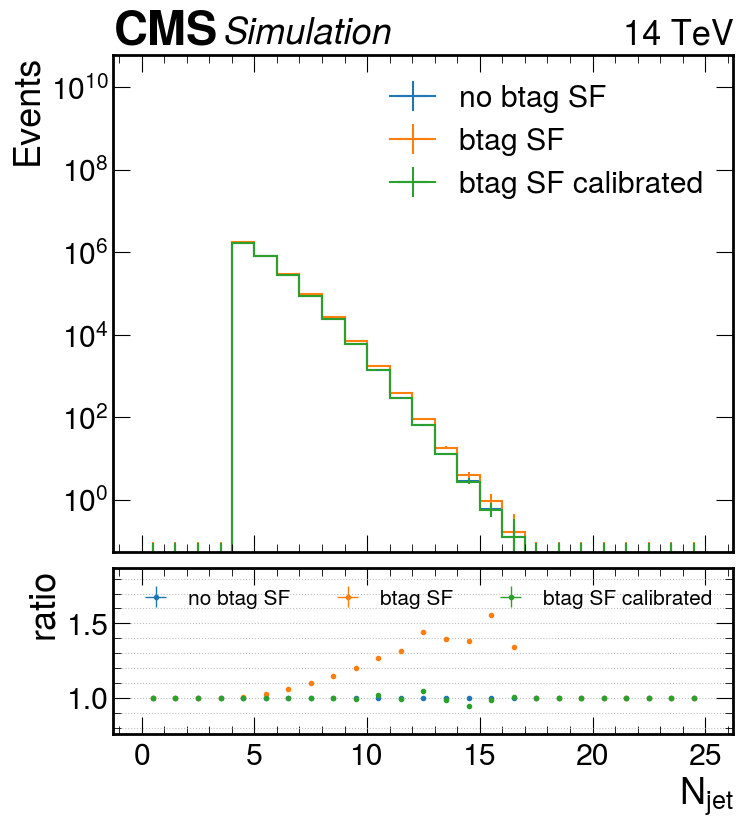

In [143]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_njet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


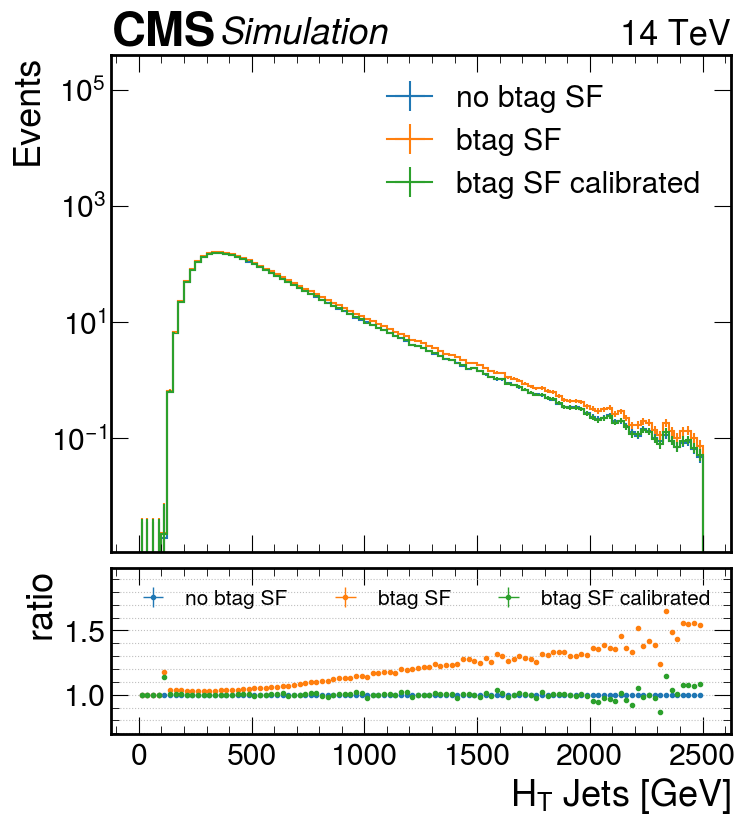

In [144]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


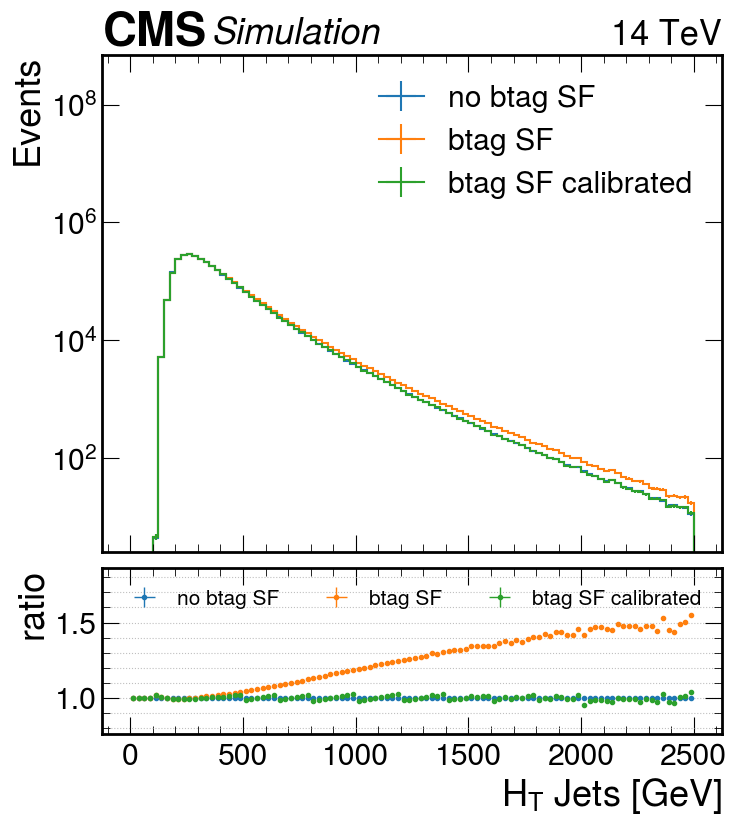

In [145]:
shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_Ht", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


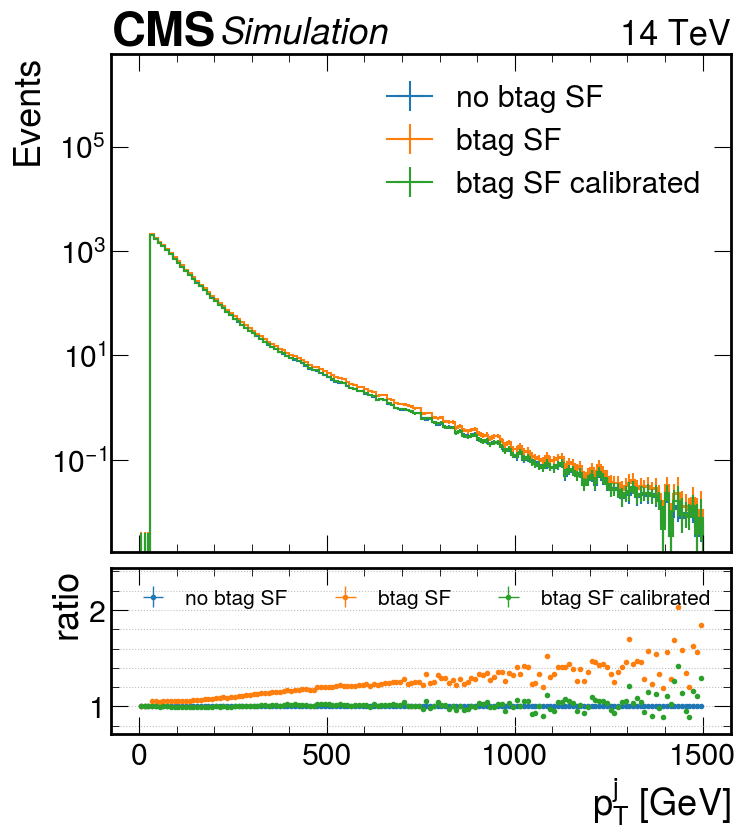

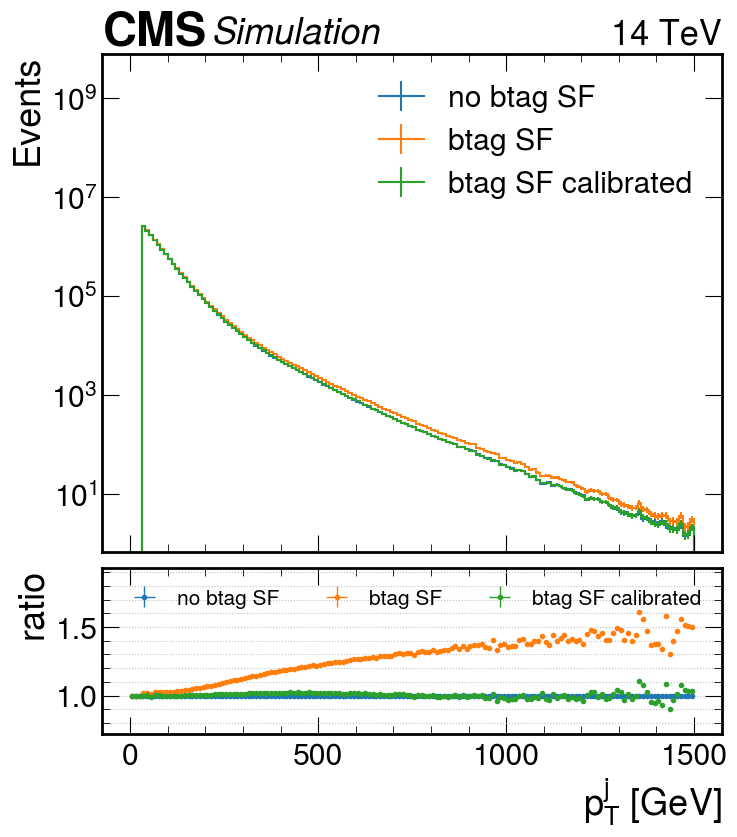

In [146]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_pt", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


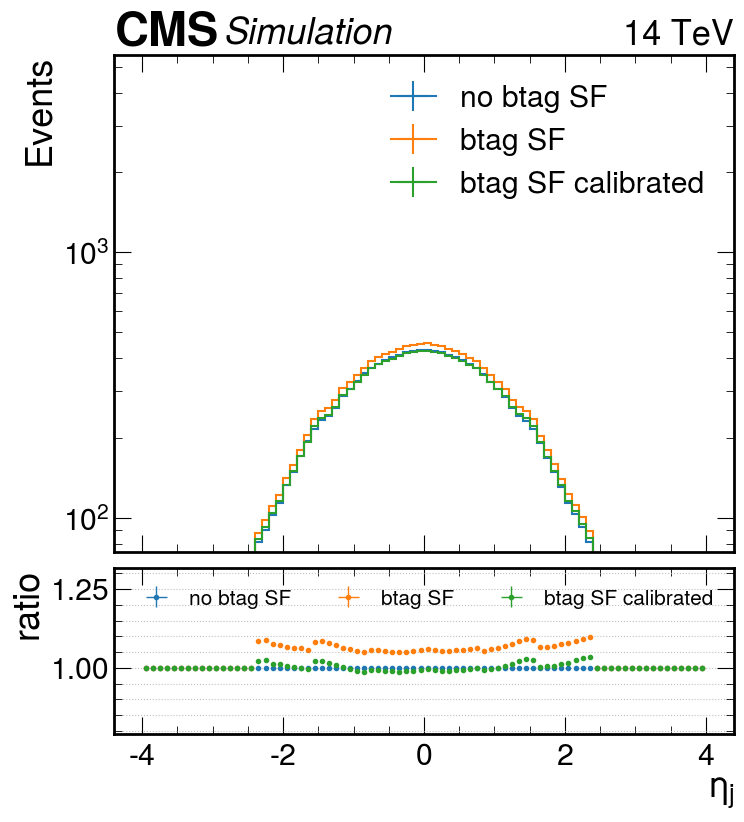

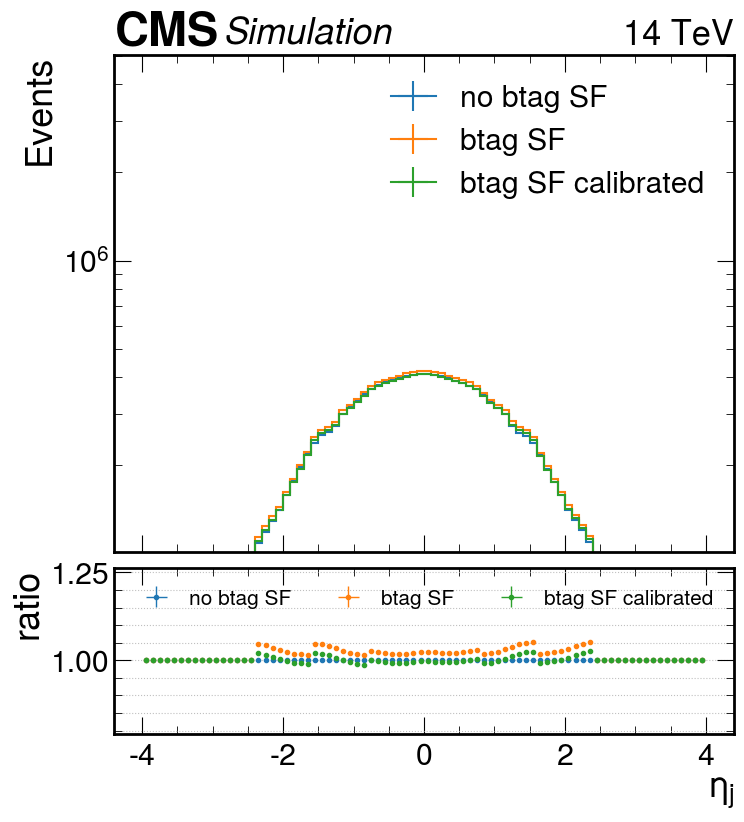

In [147]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_eta", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/3721408362.py:38: RuntimeWarning: invalid value encountered in true_divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


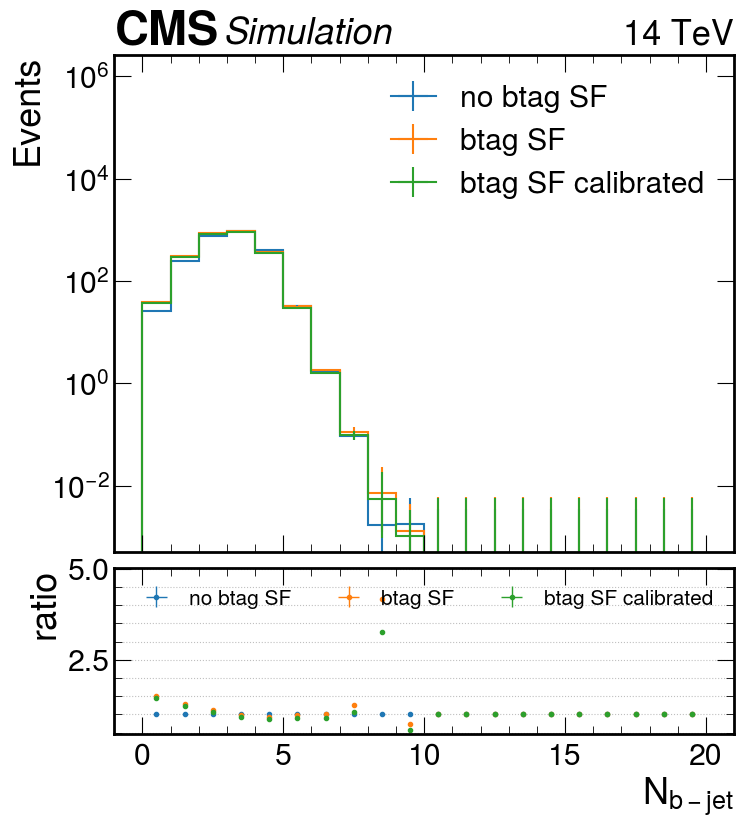

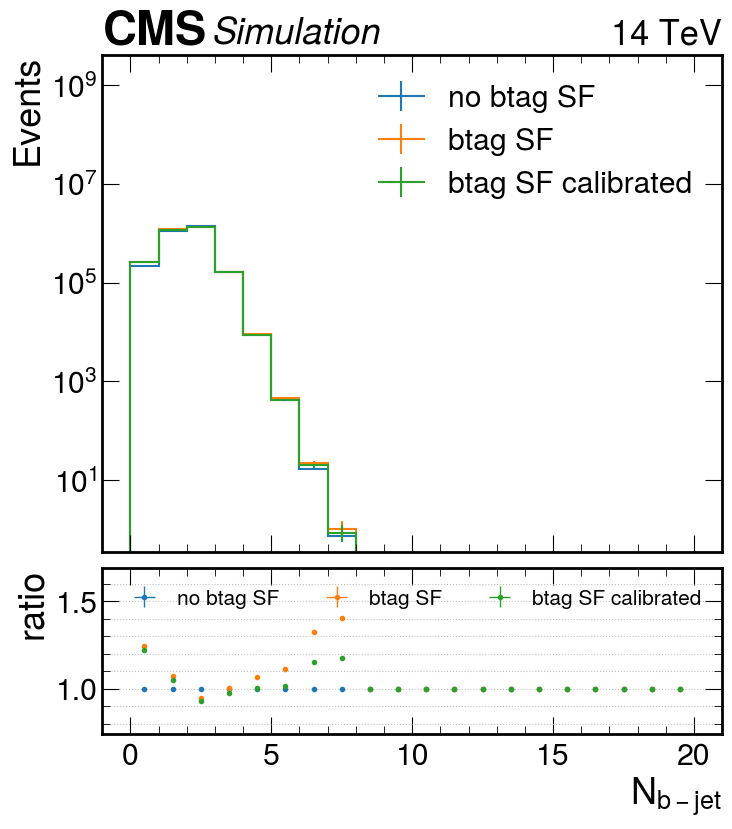

In [148]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_nbjet", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_nbjet", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


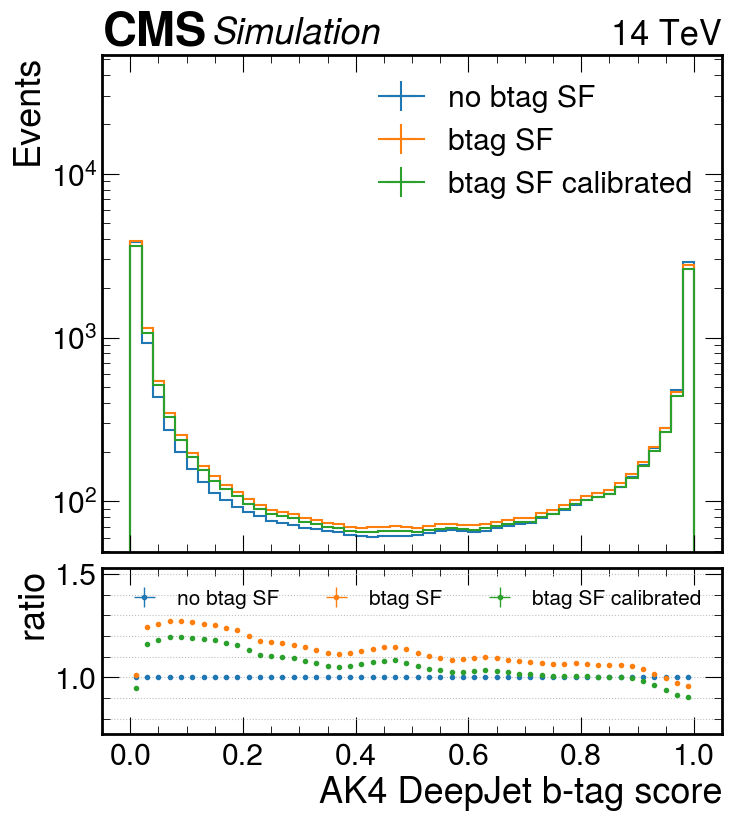

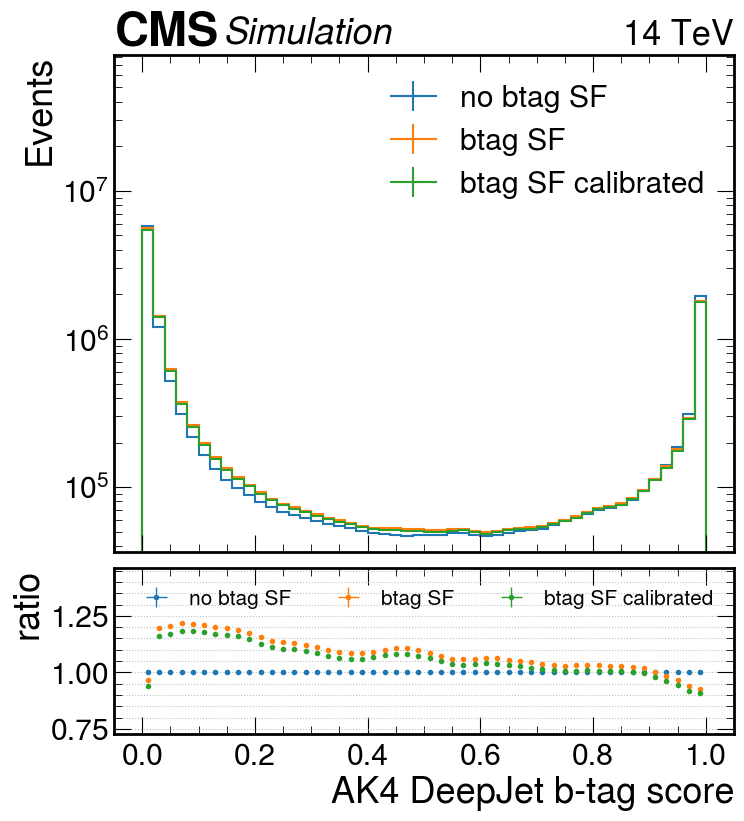

In [152]:
shapes = [
    ('ttHTobb', 'no_btagSF', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
    ('ttHTobb', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

shapes = [
    ('TTToSemiLeptonic', 'no_btagSF', '2018', "no btag SF"),
    ('TTToSemiLeptonic', 'btagSF', '2018', "btag SF"),
    ('TTToSemiLeptonic', 'btagSF_calib', '2018', "btag SF calibrated"),
]
hist_comparison(output, "hist_jet_btagDeepFlavB", shapes, ylog=True)

/work/dvalsecc/miniconda3/envs/coffea3/lib/python3.10/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)
/tmp/ipykernel_51161/1266912771.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/1266912771.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/1266912771.py:10: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/1266912771.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


Text(0, 1, 'Jet $H_T$')

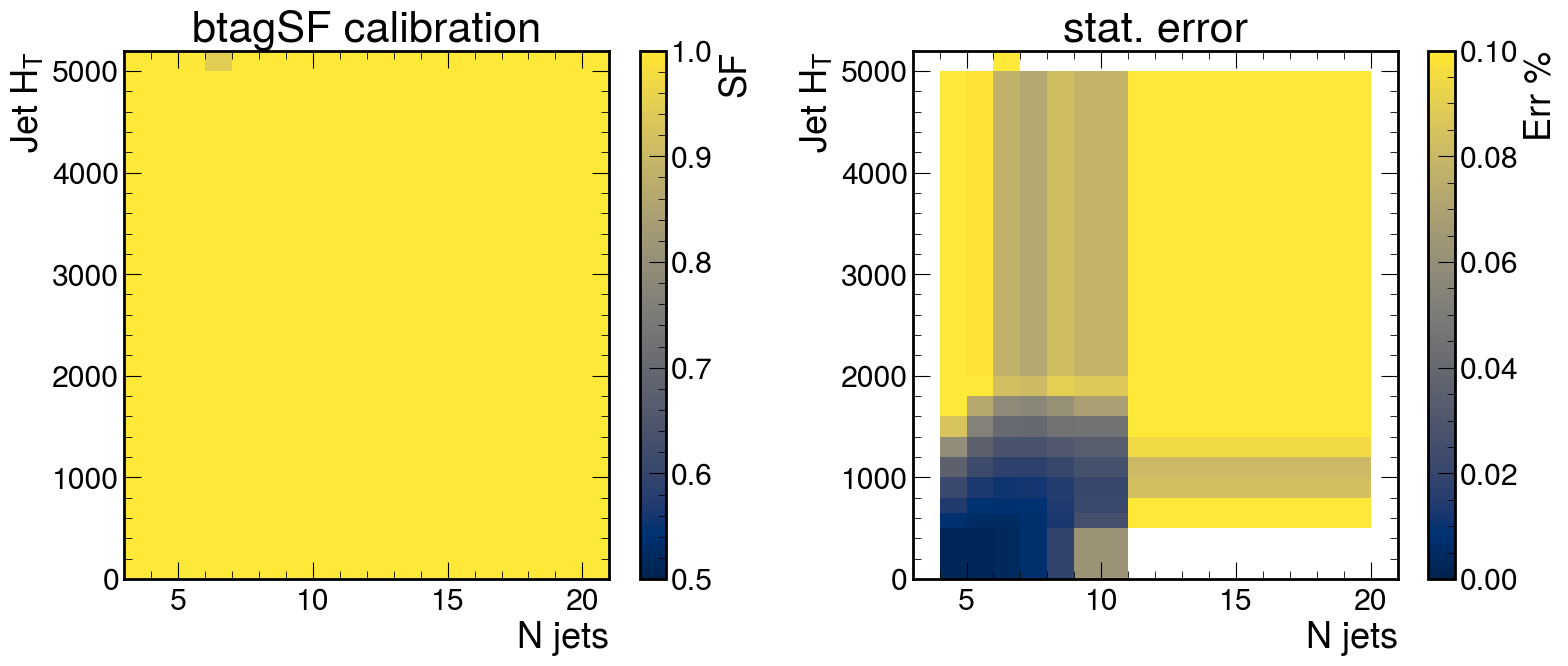

In [150]:
A = output["hist2d_Njet_Ht_bins3"].to_hist()

w_num, x, y = A['ttHTobb','no_btagSF','2018',:,:].to_numpy(flow=True)
num_var = A['ttHTobb','no_btagSF','2018',:,:].variances(flow=True)
w_denom, x, y = A['ttHTobb','btagSF_calib','2018',:,:].to_numpy(flow=True)
denom_var = A['ttHTobb','btagSF_calib','2018',:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

x_plot = x
y_plot = y
x_plot[-1] = x_plot[-2]+1
y_plot[-1] = y_plot[-2]+200
x_plot[0] = x_plot[1]-1 
y_plot[0] = -1

fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
plt.subplots_adjust(wspace=0.3)

ax.set_title("btagSF calibration")
I = ax.pcolormesh(x_plot,y_plot, ratio.T,vmax=1, vmin=0.5, cmap="cividis")
plt.colorbar(I, ax=ax, label="SF")
ax.set_xlabel("N jets")
ax.set_ylabel("Jet $H_T$")

ay.set_title("stat. error")
I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.10, vmin=0, cmap="cividis")
plt.colorbar(I, ax=ay, label="Err %")
ay.set_xlabel("N jets")
ay.set_ylabel("Jet $H_T$")

/tmp/ipykernel_51161/2468427268.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.)
/tmp/ipykernel_51161/2468427268.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2468427268.py:10: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_51161/2468427268.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


Text(0, 1, 'Jet $H_T$')

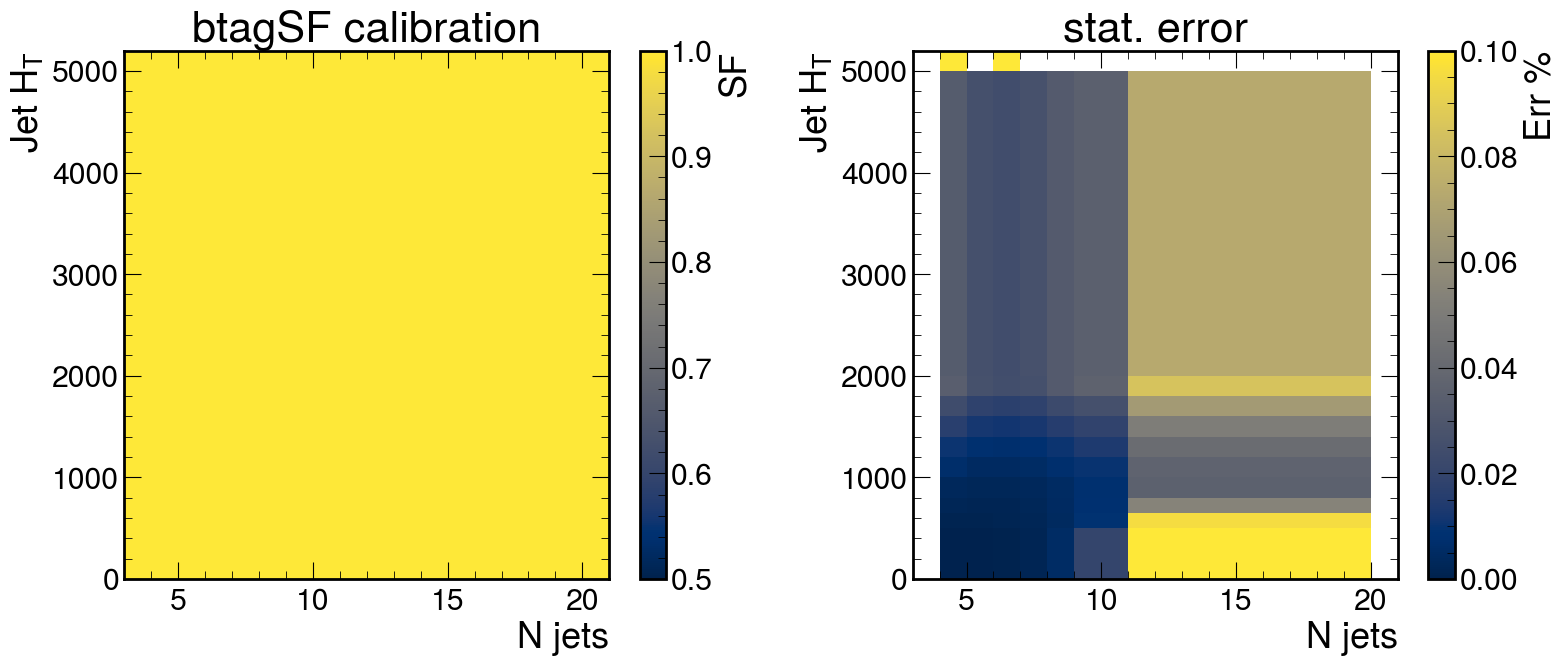

In [140]:
A = output["hist2d_Njet_Ht_bins3"].to_hist()

w_num, x, y = A['TTToSemiLeptonic','no_btagSF','2018',:,:].to_numpy(flow=True)
num_var = A['TTToSemiLeptonic','no_btagSF','2018',:,:].variances(flow=True)
w_denom, x, y = A['TTToSemiLeptonic','btagSF_calib','2018',:,:].to_numpy(flow=True)
denom_var = A['TTToSemiLeptonic','btagSF_calib','2018',:,:].variances(flow=True)

ratio= np.where( (w_denom>0)&(w_num>0), w_num/w_denom, 1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                      np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                      0.)

x_plot = x
y_plot = y
x_plot[-1] = x_plot[-2]+1
y_plot[-1] = y_plot[-2]+200
x_plot[0] = x_plot[1]-1 
y_plot[0] = -1

fig,( ax,ay) = plt.subplots(1, 2, figsize=(18, 7), dpi=100)
plt.subplots_adjust(wspace=0.3)

ax.set_title("btagSF calibration")
I = ax.pcolormesh(x_plot,y_plot, ratio.T,vmax=1, vmin=0.5, cmap="cividis")
plt.colorbar(I, ax=ax, label="SF")
ax.set_xlabel("N jets")
ax.set_ylabel("Jet $H_T$")

ay.set_title("stat. error")
I = plt.pcolormesh(x_plot,y_plot, np.ma.masked_array(ratio_err.T, ratio_err.T<= 0.),vmax=0.10, vmin=0, cmap="cividis")
plt.colorbar(I, ax=ay, label="Err %")
ay.set_xlabel("N jets")
ay.set_ylabel("Jet $H_T$")